<h1><center>HomeCredit Credit Risk Model Stability: <br>
Preprocessing, and Training with Dask, Pandas, Scikit-Learn and XGBoost, Tuned with Optuna</center></h1>

    This notebook is my submission to the HomeCredit Credit Risk Model Stability competition. While I initially aimed to use all available data, concerns about metrics and potential exploits led me to limit my effort. 
    
    The notebook includes a robust pipeline that can process and utilize whole data without memory constraints, but currently only uses data from depths 0 and 1. To include depth 2, an additional aggregation and merge step is required, which I have not implemented. The splits are limited to train-test-validation, though cross-validation can be easily added with a simple modification. Another pending task is replacing the Pandas aggregate method with Dask's aggregate method to improve inference efficiency. I attempted to serialize the entire processing pipeline into a single pickle file for use in the Kaggle environment, but pickle load failed in Kaggle envorinment, and I didn't have time to investigate. To speed up the pipeline on Kaggle, I serialized and inferred some fitted objects from pickle files. Commenting on deserialization and uncommenting pipeline connections will make the pipeline fully functional and capable of preprocessing the underlying data from scratch without needing serialized objects. 
    
    Despite these limitations, I spent time working on this dataset and gained valuable experience working with partitioned Dask dataframes, Dask-ML, learning to build scalable pipelines.

# Envorinment Setup and Imports

In [1]:
import os
import pickle
import joblib

In [2]:
from dataclasses import dataclass
@dataclass
class G:
    ENV="kaggle"
    if ENV=="kaggle":
        #datadir kaggle
        data_dir="/kaggle/input/home-credit-credit-risk-model-stability/"
    elif ENV== "colab":
        data_dir='/content/drive/My Drive/Colab Notebooks/HomeCreditCreditRiskModelStability/'
    else:
        #datadir local
        data_dir="/home/pelin/Documents/Documents/GitHub/kaggle/HomeCreditCreditRiskModelStability/"
    working_dir=os.getcwd()

In [3]:
# #kaggle env setup
if G.ENV=="kaggle":
    #!pip install ../input/daskml/dask-2024.5.0-py3-none-any.whl
    #!pip install ../input/daskml/dask_expr-1.1.0-py3-none-any.whl
    !pip install ../input/daskml/zict-3.0.0-py2.py3-none-any.whl
    !pip install ../input/daskml/tblib-3.0.0-py3-none-any.whl
    !pip install ../input/daskml/sortedcontainers-2.4.0-py2.py3-none-any.whl
    !pip uninstall -y dask_expr
    !pip install ../input/daskml/dask-2024.2.1-py3-none-any.whl
    !pip install ../input/daskml/dask_expr-0.5.1-py3-none-any.whl
    !pip install ../input/daskml/distributed-2024.2.1-py3-none-any.whl
    !pip install ../input/daskml/sparse-0.15.3-py2.py3-none-any.whl
    !pip install ../input/daskml/dask_glm-0.3.2-py2.py3-none-any.whl
    !pip install ../input/daskml/dask_ml-2024.4.4-py3-none-any.whl
    !pip install ../input/fastparquet/cramjam-2.8.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
    !pip install ../input/fastparquet/fastparquet-2024.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

Processing /kaggle/input/daskml/zict-3.0.0-py2.py3-none-any.whl
Processing /kaggle/input/daskml/tblib-3.0.0-py3-none-any.whl
Processing /kaggle/input/daskml/sortedcontainers-2.4.0-py2.py3-none-any.whl
Found existing installation: dask-expr 1.1.1
Uninstalling dask-expr-1.1.1:
  Successfully uninstalled dask-expr-1.1.1
Processing /kaggle/input/daskml/dask-2024.2.1-py3-none-any.whl
  Attempting uninstall: dask
    Found existing installation: dask 2024.5.1
    Uninstalling dask-2024.5.1:
      Successfully uninstalled dask-2024.5.1
Processing /kaggle/input/daskml/dask_expr-0.5.1-py3-none-any.whl
Processing /kaggle/input/daskml/distributed-2024.2.1-py3-none-any.whl
Processing /kaggle/input/daskml/sparse-0.15.3-py2.py3-none-any.whl
Processing /kaggle/input/daskml/dask_glm-0.3.2-py2.py3-none-any.whl
Processing /kaggle/input/daskml/dask_ml-2024.4.4-py3-none-any.whl
Processing /kaggle/input/fastparquet/cramjam-2.8.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Processing /kaggle/

In [4]:
%load_ext memory_profiler

In [5]:
import tracemalloc

In [6]:
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
import scipy.stats as stats


In [7]:
import optuna
#from optuna.integration.tensorboard import TensorBoardCallback

In [8]:
import ctypes
import glob
import sys
import psutil
import shutil
from pathlib import Path
import math

if not sys.warnoptions:
    import os, warnings
    warnings.simplefilter("once") # Change the filter in this process
    os.environ["PYTHONWARNINGS"] = "ignore"
    warnings.filterwarnings("ignore")
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [9]:
from IPython.display import clear_output
from gc import collect

In [10]:
#main modules for matrix calculations
import pandas as pd
import numpy as np
import scipy
import math

#main modules for visualisation
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
#from sklearn import tree
get_ipython().run_line_magic('matplotlib', 'inline')

In [11]:
from xgboost import XGBClassifier, plot_tree
import xgboost as xgb

In [12]:
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import log_loss

In [13]:
np.random.seed(0)
pd.set_option('display.max_colwidth', None)

In [14]:
import logging
from dask.distributed import Client, wait, progress
client = Client(n_workers=1, processes=True,  silence_logs=logging.ERROR) #threads_per_worker=14,
import dask.dataframe as dd
import dask
from dask_ml.preprocessing import OrdinalEncoder, Categorizer, MinMaxScaler
from sklearn.preprocessing import MinMaxScaler as MMs_sk
import dask.array as da
from dask_ml.decomposition import IncrementalPCA #,TruncatedSVD
from dask_ml.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from dask.array import from_array

In [15]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 4,Total memory: 30.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44005,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 30.00 GiB
Comm: tcp://127.0.0.1:41197,Total threads: 4
Dashboard: http://127.0.0.1:41959/status,Memory: 30.00 GiB
Nanny: tcp://127.0.0.1:40991,


In [16]:
from datetime import timedelta
import time
import pickle

In [17]:
for dirname, _, filenames in os.walk(G.data_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/home-credit-credit-risk-model-stability/sample_submission.csv
/kaggle/input/home-credit-credit-risk-model-stability/feature_definitions.csv
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_deposit_1.parquet
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_applprev_2.parquet
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_static_cb_0.parquet
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_static_0_0.parquet
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_credit_bureau_a_1_3.parquet
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_credit_bureau_a_1_2.parquet
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_tax_registry_b_1.parquet
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_static_0_2.parquet
/kaggle/input/home-credit-credit-risk-model-st

# Data Processing Pipeline

In [18]:
class ReadFiles:
    """Reads dataframes from source files.
    Perform a preliminary cleaning for structurally redundant columns.
    Optimizes dtypes and returns as pandas dataframe for further processing"""
    def __init__(self):
        self.internal_file_names_d0=["base","static_0"]
        self.internal_file_names_d1=["applprev_1","other_1","deposit_1","person_1","debitcard_1"]
        self.internal_file_names_d2=["applprev_2","person_2"]
        
        self.external_file_names_d0=["static_cb_0"]
        self.external_file_names_d1=["tax_registry_a_1","tax_registry_b_1","tax_registry_c_1",
                                     "credit_bureau_a_1","credit_bureau_b_1"]
        self.external_file_names_d2=["credit_bureau_a_2","credit_bureau_b_2"]
        self.special_columns=["case_id","date_decision","WEEK_NUM","MONTH","target","num_group1","num_group2"]
        self.dfs_types_rf={}

In [19]:
def try_dt_conv(x):
    x=x.copy()
    return pd.to_datetime(x, errors='ignore')

In [20]:
def detect_datetime_cols(self, df, dftype="dask"):
    if dftype=="dask":
        df=df.sample(frac=0.15, replace=False, random_state=0).compute()
    else:
        df=df.sample(frac=0.15, replace=False, random_state=0)
    date_time_cols=df.select_dtypes(["object", "string", "category"]).apply(try_dt_conv,
                                              axis=0).select_dtypes(np.datetime64).columns.tolist()

    return date_time_cols
ReadFiles.detect_datetime_cols=detect_datetime_cols

In [21]:
def select_cat_cols(self,df, dftype="dask"):
    
    cat_cols= df.select_dtypes(include=["object", "string","category"]).columns.to_list()
    
    date_cols_undetected=self.detect_datetime_cols(df, dftype)
    date_cols_detected=df.select_dtypes(include=["datetime64[ns]"]).columns.to_list()
    date_cols=date_cols_undetected+date_cols_detected
    
    cat_cols=[col for col in cat_cols if col not in date_cols]
    
    return cat_cols
ReadFiles.select_cat_cols=select_cat_cols

In [22]:
def check_numeric(self, series):
    try:
        pd.to_numeric(series, errors='raise')
        return True
    except:
        return False
ReadFiles.check_numeric=check_numeric

In [23]:
#altered from original source @ https://www.kaggle.com/code/arjanso/reducing-dataframe-memory-size-by-65
def reduce_mem_usage(self, df, verbose=True):
    # if verbose:
    #     start_mem_usg = round(df.memory_usage().sum().compute() / 1024**2,2) 
    #     print("Memory usage of dataframe is :",start_mem_usg," MB")
    date_cols_origin=df.select_dtypes("datetime64[ns]").columns.tolist()
    date_cols_detected=self.detect_datetime_cols(df)
    convert_undetected_date_dict={col:"datetime64[ns]" for col in date_cols_detected if col not in date_cols_origin}
    if len(convert_undetected_date_dict.keys())>0:
        df=df.astype(convert_undetected_date_dict)
    cat_cols_origin=df.select_dtypes("category").columns.tolist()
    cat_cols_detected=self.select_cat_cols(df)
    convert_undetected_cat_dict={col:"category" for col in cat_cols_detected if col not in cat_cols_detected}
    if len(convert_undetected_cat_dict)>0:
        df=df.astype(convert_undetected_cat_dict)
    
    cols_to_exclude=date_cols_detected+date_cols_origin+cat_cols_origin+cat_cols_detected
    cols_to_include=[col for col in df.columns if col not in cols_to_exclude]

    if verbose:
        print("converting to pandas")
        starttime = time.perf_counter()
    df = df.compute()
    client.cancel(df)
    if verbose:
        duration = timedelta(seconds=time.perf_counter()-starttime)
        print("computation time: ", duration)

    if verbose:
        print("converting numercis")
    verified_numerics=[col for col in cols_to_include if self.check_numeric(df[col])]
    
    for col in verified_numerics:
        mx = df[col].max()
        mn = df[col].min()
        
        ints = ['int16', 'int32', 'int64', "uint16", "uint32", "uint64"]

        if df[col].dtype in  ints:
            if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                df[col] = df[col].astype(pd.Int8Dtype())
            elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                df[col] = df[col].astype(pd.Int16Dtype())
            elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                df[col] = df[col].astype(pd.Int32Dtype())
            elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                df[col] = df[col].astype(pd.Int64Dtype())
        else:
            df[col] = df[col].astype(pd.Float32Dtype())
            
    convert_non_verified_dict={col:"category" for col in cols_to_include if col not in verified_numerics}
    if len(convert_non_verified_dict.keys())>0:
        df=df.astype(convert_non_verified_dict)
        
    # Print final result
    # if verbose:
    #     mem_usg = round(df.memory_usage().sum()/ 1024**2,2) 
    #     print(f"Memory usage after completion is: {mem_usg} MB. This is {round(100*mem_usg/start_mem_usg,0)} % of the initial size")
    return df
ReadFiles.reduce_mem_usage=reduce_mem_usage

In [24]:
def fix_booleans(self, df, dt_dict):
    for key, val in dt_dict.items():
        if val=="Float32":
            uniques_in_col=list(df[key].unique())
            uniques_in_col=[x for x in uniques_in_col if pd.notnull(x)]
            if  (uniques_in_col == ["True", "False"]) or (uniques_in_col == ["False","True"]):
                df[key]=np.where(df[key]=="True", 1.0, 
                                np.where(df[key]=="False",0.0, np.nan))
                df[key]=df[key].replace(".",np.nan)
            elif (uniques_in_col == [True, False]) or (uniques_in_col == [False, True]):
                df[key]=df[key].astype("object")
                df[key]=np.where(df[key]==True, 1.0, 
                                np.where(df[key]==False, 0.0, np.nan))
    df=df.astype(dt_dict)
    return df
ReadFiles.fix_booleans=fix_booleans

In [25]:
def get_folder_source_tar(self, location, source, ftype,test_type, pno, verbose=True):
    
    if G.ENV=="kaggle":
        #path to input docs kaggle
        cwd="/kaggle/input/home-credit-credit-risk-model-stability"
    else:
        #cwd local
        cwd=G.working_dir
        
    if pno=="p1":
        location=location.replace(cwd,"")
    
    path = cwd+location
    if pno=="p1" and G.ENV=="kaggle":
        path=location
    if test_type=="submission_test":
        path=cwd+location
    if verbose:
        print(f"printing path to directory for reading files: {path}")
    folder = glob.glob(os.path.join(path, "*.parquet"))
    source_targets=[ftype+"_"+filename for filename in source]
    return folder, source_targets
ReadFiles.get_folder_source_tar=get_folder_source_tar

In [26]:
def read_files(self, location, source, ftype, test_type, verbose=True):
    dfs={}
    folder, source_targets=self.get_folder_source_tar(location=location, source=source,pno="p1", ftype=ftype,test_type=test_type, verbose=verbose)
    if verbose:
        print("*"*33+ftype+" "+"files"+"*"*33)
    for filename in folder:
        # read the csv file
        for source_target_name in source_targets:
            if filename.split("/")[-1].startswith(source_target_name):
                if verbose:
                    print(filename.split("/")[-1].split(".")[0])
                df = dd.read_parquet(filename, use_nullable_dtypes=True)
                df = client.persist(df) 
                df = df.repartition(partition_size="100MB")
                df = df.replace([np.inf, -1*np.inf], np.nan)
                if ftype == "train":
                    if verbose:
                        print("selecting date cols converting to datetime")
                        starttime = time.perf_counter()
                    date_cols=self.detect_datetime_cols(df)
                    date_cols_dict={col:'datetime64[ns]' for col in date_cols}
                    df=df.astype(date_cols_dict)
                    if verbose:
                        duration = timedelta(seconds=time.perf_counter()-starttime)
                        print("computation time: ", duration)
                    if verbose:
                        print("selecting cat cols converting to category")
                        starttime = time.perf_counter()
                    category_columns=self.select_cat_cols(df)
                    cat_cols_dict={col:"category" for col in  category_columns}
                    df=df.astype(cat_cols_dict)
                    if verbose:
                        duration = timedelta(seconds=time.perf_counter()-starttime)
                        print("computation time: ", duration)
                    if verbose:
                        print("reducing memory usage")
                        starttime = time.perf_counter()
                    df = self.reduce_mem_usage(df, verbose=verbose)
                    if verbose:
                        duration = timedelta(seconds=time.perf_counter()-starttime)
                        print("computation time: ", duration)
                        # print(df.dtypes.value_counts())
                    train_key=filename.split("/")[-1].split(".")[0]
                    if (train_key[:-1]==ftype+"_applprev_1_") or (train_key[:-1]== ftype+"_static_0_") or (train_key[:-1]==ftype+"_credit_bureau_a_1_"):
                        train_key=train_key[:-1]
                    self.dfs_types_rf[train_key]=df.dtypes.to_dict()
                else:
                    test_key=filename.split("/")[-1].split(".")[0]
                    if (test_key[:-1]==ftype+"_applprev_1_") or (test_key[:-1]== ftype+"_static_0_") or (test_key[:-1]==ftype+"_credit_bureau_a_1_"):
                        test_key=test_key[:-1]                    
                    corresponding_train_key="train"+test_key[4:]
                    dtypes_dict=self.dfs_types_rf[corresponding_train_key].copy()
                    if test_key == "test_base":
                        if verbose:
                            print(f"printing test_type {test_type}")
                        if test_type=="submission_test":
                            del dtypes_dict["target"]
                            collect()
                    df=df.compute()
                    client.cancel(df)
                    train_date_infered=[key for key, val in dtypes_dict.items() if val == "datetime64[ns]"]
                    df[train_date_infered]=df[train_date_infered].apply(pd.to_datetime, errors="coerce")
                    if test_type=="submission_test":
                        df=self.fix_booleans(df, dtypes_dict)
                    else:
                        df=df.astype(dtypes_dict)
                    # if verbose:
                    #     print(test_key)
                    #     if test_type == "train":
                    #         if test_key == "test_base":
                    #             print(f"read_files method valid-test splits NA count {df['target'].isna().sum()}")
                dfs[filename.split("/")[-1].split(".")[0]]=df
                del df 
                collect()
    #clear_output()
    collect()
    return dfs
ReadFiles.read_files=read_files

In [27]:
def get_source(self, int_or_ex, dept):
    if (int_or_ex == "int") & (dept == 0):
        source = self.internal_file_names_d0
    elif (int_or_ex == "ext") & (dept == 0):
        source = self.external_file_names_d0
    elif (int_or_ex == "int") & (dept == 1):
        source = self.internal_file_names_d1
    elif (int_or_ex == "ext") & (dept == 1):
        source =  self.external_file_names_d1
    elif (int_or_ex == "int") & (dept == 2):
        source = self.internal_file_names_d2
    else:
        source = self.external_file_names_d2
    return source
ReadFiles.get_source=get_source

In [28]:
def get_files(self, ftype, int_or_ex, depts,test_type, loca, verbose=True):
    sources=[]
    for dept in depts:
        source= self.get_source(int_or_ex, dept)
        sources+=source
    location=os.path.join(loca,ftype)
    if verbose:
        print(location)
    df_dicts=self.read_files(location,sources,ftype, test_type, verbose=verbose)
    return df_dicts
ReadFiles.get_files=get_files

In [29]:
class Create_Dataset(ReadFiles):
    """ Takes dictionary of dataframes, aggragates and merges to single dataframe.
    Cleans structurally redundant columns, optimizes dtypes for processing and writing to parquet. 
    When dictionary of dataframes isn't supplied at apply_processing, calls ReadFiles class to read from source.
    Always need to process train set first to find and initialize columns to be dropped out"""
    def __init__(self):
        super(Create_Dataset,self).__init__()
        self.cols_to_drop_dict={}
        self.cols_to_drop_dict_bac={}
        self.dtypes_train={}
        self.dtypes_train_bac={}
        self.train_cols=None
        self.desired_cols_dict={}
        self.agg_func_dict_holder={}
        self.col_names_df_holder={}

In [30]:
def concat_partitioned_sources_d0_1(self,ftype, df_dict):
    keys_list = list(df_dict.keys())
    applprev_1_keys = []
    static_0_keys = []
    credit_bureau_a_1_keys = []
    for key in keys_list:
        if key[:-1] == ftype+"_applprev_1_":
            applprev_1_keys.append(key)
        elif key[:-1] == ftype+"_static_0_":
            static_0_keys.append(key)
        elif key[:-1] == ftype+"_credit_bureau_a_1_":
            credit_bureau_a_1_keys.append(key)
    if len(applprev_1_keys) >0:     
        applprev_1 = pd.concat([df_dict[key] for key in applprev_1_keys], ignore_index=True)
        df_dict[ftype+"_applprev_1"] = applprev_1
    if len(static_0_keys) >0:
        static_0 = pd.concat([df_dict[key] for key in static_0_keys], ignore_index=True)
        df_dict[ftype+"_static_0"] = static_0
    if len(credit_bureau_a_1_keys)>0:
        credit_bureau_a_1 = pd.concat([df_dict[key] for key in credit_bureau_a_1_keys], ignore_index=True)
        df_dict[ftype+"_credit_bureau_a_1"] = credit_bureau_a_1

    [df_dict.pop(key) for key in applprev_1_keys+static_0_keys+credit_bureau_a_1_keys]
    collect()
    
    return df_dict
Create_Dataset.concat_partitioned_sources_d0_1 = concat_partitioned_sources_d0_1

In [31]:
def convert_to_dask_temp(self,df):
    try:
        os.remove("inprocess.parquet")
    except Exception:
        pass
    df.to_parquet("inprocess.parquet")
    del df
    collect()
    df=dd.read_parquet("inprocess.parquet",engine='fastparquet')
    #df = client.persist(df) 
    df= df.repartition(partition_size="100MB")
    return df
Create_Dataset.convert_to_dask_temp=convert_to_dask_temp

In [32]:
def remove_95_miss_cols_pp(self, df, verbose=True):
    cols_to_drop=[]
    cols_to_check=[col for col in df.columns if col not in self.special_columns]
    len_df_cols=len(cols_to_check)
    df_lenght=len(df.index)
    df=self.convert_to_dask_temp(df)
    df=df.replace('<NA>',np.nan)
    miss_value_counts=df[cols_to_check].isna().sum().compute()
    for i, col in enumerate(cols_to_check):
        # if verbose:
        #     print(f" currently processing {col}, % col processed  {i/len_df_cols}")
        null_count= miss_value_counts.loc[col]
        if (null_count/df_lenght) > 0.95:
            cols_to_drop.append(col)
            # if verbose:
            #     print(f"col_to_drop: {col}")
    if verbose:
        print("dropping columns with more then 95% NA")
    df=df.drop(columns=cols_to_drop)
    collect()
    return df, cols_to_drop
Create_Dataset.remove_95_miss_cols_pp=remove_95_miss_cols_pp

In [33]:
def remove_cat_cols_high_no_card_pp(self,df,verbose=True):
    cols_to_drop=[]
    df_cat_cols=self.select_cat_cols(df,dftype="dask")
    len_df_cat_cols=len(df_cat_cols)
    nunique_counts=df.nunique().compute()
    for i,col in enumerate(df_cat_cols):
        # if verbose:
        #     print(f"% col processed  {i/len_df_cat_cols}")
        if col not in self.special_columns:
            # if verbose:
            #     print(col)
            card=nunique_counts.loc[col]
            if (card >200) | (card==1):
                cols_to_drop.append(col)
                # if verbose:
                #     print(f"col_to_drop: {col}")
    if verbose:
        print("dropping columns with high cardinality")
    df=df.drop(columns=cols_to_drop).compute()
    client.cancel(df)
    collect()
    return df, cols_to_drop
Create_Dataset.remove_cat_cols_high_no_card_pp=remove_cat_cols_high_no_card_pp

In [34]:
def clean_test_wr_train(df, drop_col_list, col_dtype_dict):
    drop_col_in_test=[col for col in drop_col_list if col in df.columns]           
    df = df.drop(columns=drop_col_in_test)
    collect()
    cols_train = list(col_dtype_dict.keys())
    for col in cols_train:
        if col not in df.columns:
            df[col]=np.nan
    df=df.astype(col_dtype_dict)
    return df
Create_Dataset.clean_test_wr_train=clean_test_wr_train

In [35]:
def clean(self, df_dict, ftype,test_type, verbose=True, bac=True):
    dict_keys=list(df_dict.keys())
    df_dict_new={}
    
    with open("/kaggle/input/homecredit-pm/cols_to_drop_dict.pickle", "rb") as infile:
        self.cols_to_drop_dict = pickle.load(infile)
    with open("/kaggle/input/homecredit-pm/cols_to_drop_dict_bac.pickle", "rb") as infile:
        self.cols_to_drop_dict_bac = pickle.load(infile)  
    with open("/kaggle/input/homecredit-pm/dtypes_train.pickle", "rb") as infile:
        self.dtypes_train = pickle.load(infile)
    with open("/kaggle/input/homecredit-pm/dtypes_train_bac.pickle", "rb") as infile:
        self.dtypes_train_bac = pickle.load(infile)
    for key in dict_keys:
        if verbose:
            print(f"Cleaning {ftype}: {key}")
        df=df_dict.pop(key)

        if ftype == "train":
            #stringarrr_cols=df.select_dtypes(include=["category","object"]).columns.to_list()
            
            #stringarrr_cols_col_dtype_conv_dict={col:"category" for col in stringarrr_cols}
            #df=df.astype(stringarrr_cols_col_dtype_conv_dict)
            
            #date_cols=self.detect_datetime_cols(df, dftype="pandas")
            #date_cols_dtype_conv_dict={col:'datetime64[ns]' for col in date_cols if df[col].dtype != np.datetime64}
            #df=df.astype(date_cols_dtype_conv_dict)
            
            #df, cols_to_drop_n=self.remove_95_miss_cols_pp(df, verbose=verbose)
            #df, cols_to_drop_c=self.remove_cat_cols_high_no_card_pp(df, verbose=verbose)
            #cols_to_drop=cols_to_drop_n+cols_to_drop_c
            
            #cat_cols=self.select_cat_cols(df,dftype="pandas")
            #cat_cols_dtype_conv_dict={col:"category" for col in cat_cols}
            #df=df.astype(cat_cols_dtype_conv_dict) 
            
            if bac:
                #self.cols_to_drop_dict_bac[key]=cols_to_drop
                #self.dtypes_train_bac[key]=df.dtypes.to_dict()
                df = clean_test_wr_train(df, 
                                         drop_col_list=self.cols_to_drop_dict_bac[key], 
                                         col_dtype_dict=self.dtypes_train_bac[key]) 
            else:
                #self.cols_to_drop_dict[key]=cols_to_drop
                #self.dtypes_train[key]=df.dtypes.to_dict()
                df = clean_test_wr_train(df, 
                                         drop_col_list=self.cols_to_drop_dict[key], 
                                         col_dtype_dict=self.dtypes_train[key])
        else:
            # if verbose:
            #     if (test_type == "train")  &  (key == "test_base"):
            #         print(f"clean method beginning valid-test splits NA count {df['target'].isna().sum()}")
            if bac:
                df = clean_test_wr_train(df, 
                                         drop_col_list=self.cols_to_drop_dict_bac["train"+key[4:]], 
                                         col_dtype_dict=self.dtypes_train_bac["train"+key[4:]])           
            else:
                df = clean_test_wr_train(df, 
                                         drop_col_list=self.cols_to_drop_dict["train"+key[4:]], 
                                         col_dtype_dict=self.dtypes_train["train"+key[4:]])
                        
        df_dict_new[key]=df
        # if verbose:
        #     if (test_type == "train")  &  (key == "test_base"):
        #         print(f"clean method end valid-test splits NA count {df['target'].isna().sum()}")
        #clear_output()
    del df_dict
    collect()
    return  df_dict_new
Create_Dataset.clean=clean

In [36]:
def get_mode(x):
    x=x.copy()
    return x.mode(dropna=False).iloc[-1]

In [37]:
def get_aggr_methods(self, df):
    df_cols=df.columns
    agg_func_dict={}
    col_names_df=[]
    cat_cols=self.select_cat_cols(df,dftype="pandas")
    for col in df_cols:
        if (col[-1] in ("P", "A", "D", "M", "T", "L")) or ("num_group" in col):
            if col[-1] in ("P", "A", "D"):
                agg_func_dict[col]=["min","max","first","last","mean"]
                col_names_df+=[col+"_min",col+"_max",col+"_first",col+"_last",col+"_mean"]
            elif col[-1]=="M":
                agg_func_dict[col]=["first","last",get_mode]
                col_names_df+=[col+"_first",col+"_last",col+"_mode"]
            else:
                if col in cat_cols:
                    agg_func_dict[col]=["first","last", get_mode]
                    col_names_df+=[col+"_first",col+"_last",col+"_mode"]
                else:
                    agg_func_dict[col]=["min","max","first","last","mean"]
                    col_names_df+=[col+"_min",col+"_max",col+"_first",col+"_last",col+"_mean"]
    return agg_func_dict, col_names_df
Create_Dataset.get_aggr_methods=get_aggr_methods

In [38]:
def aggragete(self, df_dict, ftype,verbose=True):
    df_dict_keys=list(df_dict.keys())
    new_df_dict={}
    for key in df_dict_keys:
        try:
            last_letter=int(key[-1])
        except:
            last_letter=key[-1]
        if (last_letter =='e') or  (last_letter==0):
            if verbose:
                print(f"Aggragating {key}")
            df=df_dict.pop(key)
            df=df.astype({"case_id":"int32"})
            new_df_dict[key]=df
            del df
            collect()
        else:
            if verbose:
                print(f"Aggragating {key}")
            starttime = time.perf_counter()
            df_agg=df_dict.pop(key)
            df_agg=df_agg.astype({"case_id":"int32"})
            if df_agg.shape[0]>0:
                if ftype=="train":
                    agg_func_dict, col_names_df=self.get_aggr_methods(df_agg)
                    self.agg_func_dict_holder[key]=agg_func_dict
                    self.col_names_df_holder[key]= col_names_df
                else:
                    agg_func_dict=self.agg_func_dict_holder["train"+key[4:]]
                    col_names_df=self.col_names_df_holder["train"+key[4:]]
                    
                df_agg=df_agg.groupby("case_id",observed=True).agg(agg_func_dict)  
                df_agg.columns=col_names_df
                df_agg=df_agg.reset_index()
                new_df_dict[key]=df_agg
                del df_agg
                collect()
            duration = timedelta(seconds=time.perf_counter()-starttime)
            if verbose:
                print("computation time: ", duration)
    del df_dict
    collect()
    return new_df_dict
Create_Dataset.aggragete=aggragete

In [39]:
def clean_dubs(self, df):
    # drop dublicate rows
    df=df.drop_duplicates()
    
    # check if columns are dublicate by sampling 10% of data and cleaning if yes
    df_sample=df.sample(frac=0.2)
    df_T=df_sample.T
    df_T=df_T.drop_duplicates()
    df_sample=df_T.T
    del df_T
    collect()
    desired_cols=list(df_sample.columns)
    del df_sample
    df=df[desired_cols]
    collect()
    return df , desired_cols
Create_Dataset.clean_dubs=clean_dubs

In [40]:
def clean_dubs_df_dict(self, df_dict, ftype, verbose=True):
    df_dict_keys=list(df_dict.keys())
    df_dict_cleaned={}
    
    with open("/kaggle/input/homecredit-pm/desired_cols_dict.pickle", "rb") as infile:
        self.desired_cols_dict = pickle.load(infile)
        
    for key in df_dict_keys:
        if verbose:
            print(f"cleaning dublicates {key}")
        df=df_dict.pop(key)
        if ftype=="train":
            #df, desired_cols=self.clean_dubs(df)
            #self.desired_cols_dict[key]=desired_cols
            #df_dict_cleaned[key]=df
            df_dict_cleaned[key]=df[self.desired_cols_dict[key]]
        else:
             df_dict_cleaned[key]=df[self.desired_cols_dict["train"+key[4:]]]
        del df
        collect()
    del df_dict
    collect()
    return df_dict_cleaned
Create_Dataset.clean_dubs_df_dict=clean_dubs_df_dict

In [41]:
def get_path(self, ftype, source_type):
    #cwd local
    cwd=G.working_dir
    if ftype=="train":
        location="train_df_dict"
    else:
        location="test_df_dict"

    if source_type=="internal":
        folder="internal"
    else: 
        folder="external"
    path = os.path.join(cwd, location, folder)
    return path
Create_Dataset.get_path=get_path

In [42]:
def save_df_dict(self, ftype, source_type, operation, df_dict=None, verbose=True):
    path=self.get_path(ftype=ftype, source_type=source_type)
    
    if operation=="save":
        if os.path.isdir(path):
            shutil.rmtree(path)
        Path(path).mkdir(parents=True, exist_ok=True)

        for key, df in df_dict.items():
            if verbose:
                print(key)
            df.to_parquet(os.path.join(path, key+".parquet"))
        del df_dict
        collect()
    else:
        df_dict={}
        folder = glob.glob(os.path.join(path, "*.parquet"))
        for filename in folder:
            df = pd.read_parquet(filename, use_nullable_dtypes=True)
            df_key=filename.split("/")[-1].split(".")[0]
            df_dict[df_key]=df
        return df_dict
Create_Dataset.save_df_dict = save_df_dict

In [43]:
def create_merge_dir(self, ftype, depts,loca,test_type,  verbose=True): #df_dict_int=None, df_dict_ext=None,
    #processing internal files
    if verbose:
        print("Reading internal files")
        print(loca)
    df_dict_int=self.get_files(ftype,int_or_ex="int",depts=depts, test_type=test_type, loca=loca, verbose=verbose)
    
    if verbose:
        print(f"Processing internal sources: Concatenating partitioned internal sources in {ftype}")
    df_dict_int = self.concat_partitioned_sources_d0_1(ftype, df_dict_int)

    if verbose: 
        print(f"Processing internal sources: Cleaning concatenated dataframes in {ftype}")
    df_dict_int = self.clean(df_dict_int, ftype,test_type=test_type, verbose=verbose)
    
    if verbose:
        print(f"Processing internal sources: Aggregating on case_id in {ftype}")
    df_dict_int = self.aggragete(df_dict_int, ftype, verbose=verbose)

    if verbose: 
        print(f"Processing internal sources: Cleaning aggragated dataframes in {ftype}")
    df_dict_int = self.clean(df_dict_int, ftype, test_type=test_type, verbose=verbose)

    if verbose:
        print(f"Processing internal sources: cleaning dublicate columns {ftype}")
    df_dict_int = self.clean_dubs_df_dict(df_dict_int,ftype, verbose=verbose)
    
    if verbose:
        print(f"Saving internal sources dictionary to folder and removing dataframe dictionary from memory for {ftype} files")
    self.save_df_dict(ftype=ftype, df_dict=df_dict_int, operation="save", source_type="internal")
    df_dict_int=True
    #clear_output()
    # libc = ctypes.CDLL("libc.so.6")
    # libc.malloc_trim(0)

    
    #processing external files
    if verbose:
        print("Reading external files")
    df_dict_ext=self.get_files(ftype,int_or_ex="ext",depts=depts,loca=loca,test_type=test_type, verbose=verbose)
    
    if verbose:
        print(f"Processing external sources: Concatenating partitioned external sources in {ftype}")
    df_dict_ext = self.concat_partitioned_sources_d0_1(ftype, df_dict_ext)

    if verbose: 
        print(f"Processing external sources: Cleaning concatenated dataframes in {ftype}")
    df_dict_ext = self.clean(df_dict_ext, ftype, test_type=test_type, verbose=verbose) 
    
    if verbose:
        print(f"Processing external sources: Aggregating on case_id in {ftype}")
    df_dict_ext = self.aggragete(df_dict_ext, ftype, verbose=verbose)
    
    if verbose: 
        print(f"Processing external sources: Cleaning aggragated dataframes in {ftype}")
    df_dict_ext = self.clean(df_dict_ext, ftype, verbose=verbose, test_type=test_type, bac=False) 

    if verbose:
        print(f"Processing external sources: cleaning dublicate columns {ftype}")
    df_dict_ext = self.clean_dubs_df_dict(df_dict_ext, ftype, verbose=verbose)    
    self.save_df_dict(ftype=ftype, df_dict=df_dict_ext, operation="save", source_type="external")
    df_dict_ext = True
    #clear_output()
    # libc.malloc_trim(0)
    return df_dict_int, df_dict_ext
Create_Dataset.create_merge_dir = create_merge_dir

In [44]:
def merge_dfs(self, ftype, verbose=True): 

    if verbose:
        print("Joining internal sources")
    path_int=self.get_path(ftype=ftype, source_type="internal")
    folder_int = glob.glob(os.path.join(path_int, "*.parquet"))
    base=[filename for filename in folder_int if filename.split("/")[-1].split(".")[0]==ftype+"_base"]
    df_base=pd.read_parquet(base[0], use_nullable_dtypes=True)
    folder_int_exbase=[filename for filename in folder_int if filename.split("/")[-1].split(".")[0]!=ftype+"_base"]
    del base
    collect()
    df_base=df_base.astype({"case_id":"int32"})
    df_base=df_base.set_index("case_id")
    
    folder_int_exbase.sort()
    for filename in folder_int_exbase:

        key=filename.split("/")[-1].split(".")[0]
        key_name=key.replace("train","")
        key_name=key_name.replace("test","")
        if verbose:
            print(f"joining {key_name}")
        df=pd.read_parquet(filename, use_nullable_dtypes=True)
        df=df.astype({"case_id":"int32"})
        df_base=df_base.join(df.set_index("case_id"), 
                             how="left", rsuffix="_"+key_name)
        del df
        collect()

    del folder_int
    del folder_int_exbase
    collect()
        
    if verbose:
        print("Joining external sources")
    path_ext=self.get_path(ftype=ftype, source_type="external")
    folder_ext = glob.glob(os.path.join(path_ext, "*.parquet"))
    
    folder_ext.sort()
    for filename in folder_ext:
        key=filename.split("/")[-1].split(".")[0]
        key_name=key.replace("train","")
        key_name=key_name.replace("test","")
        if verbose:
            print(f"joining {key}")
        df=pd.read_parquet(filename, use_nullable_dtypes=True)
        df=df.astype({"case_id":"int32"})
        df_base=df_base.join(df.set_index("case_id"), 
                             how="left", rsuffix="_"+key_name)
        del df
        collect()

    del folder_ext
    collect()
    # if verbose:
    #     print(f"merge_df method valid-test splits NA count {df_base['target'].isna().sum()}")
    return df_base
Create_Dataset.merge_dfs=merge_dfs

In [45]:
def clean_df(self, df, ftype, test_type, verbose=True):
    if verbose:
        print(f"Cleaning {ftype} dataframe")
    if ftype == "train":
        if verbose:
            print("finding categorical")
        stringarrr_cols=df.select_dtypes(include=["object", "string", "category"]).columns.to_list()
        cat_col_dtype_conv_dict={col:"category" for col in stringarrr_cols}
        if verbose:
            print("finding datetime")    
        date_cols=self.detect_datetime_cols(df, dftype="pandas")
        date_cols_conv_dict={col:"datetime64[ns]" for col in date_cols if df[col].dtype != np.datetime64}   
        self.clean_df_merged_dtype_dict1={**cat_col_dtype_conv_dict, **date_cols_conv_dict}
        del cat_col_dtype_conv_dict
        del date_cols_conv_dict
        del stringarrr_cols
        del date_cols
        collect()
        df=df.astype(self.clean_df_merged_dtype_dict1)
    else:
        df=df.astype(self.clean_df_merged_dtype_dict1)

    if ftype == "train":
        if verbose:
            print("finding removing 95% miss cols") 
        #df, cols_to_drop_n=self.remove_95_miss_cols_pp(df, verbose=verbose)
        #clear_output()
        if verbose:
            print("finding removing high cardinality catergorical cols") 
        #df, cols_to_drop_c=self.remove_cat_cols_high_no_card_pp(df,  verbose=verbose)
        #clear_output()
        #self.cols_to_drop_pp=cols_to_drop_n+cols_to_drop_c
        with open("/kaggle/input/homecredit-pm/cols_to_drop_pp.pickle", "rb") as infile:
            self.cols_to_drop_pp = pickle.load(infile)
        df=df.drop(columns=self.cols_to_drop_pp)
        #del cols_to_drop_n
        #del cols_to_drop_c
        collect()
        self.d_types=df.dtypes.to_dict()
    else:
        df=df.drop(columns=self.cols_to_drop_pp)
        collect()
        df=df.astype(self.d_types, errors="ignore")
        # if verbose:
        #     print(f"clean_df method valid-test splits NA count {df['target'].isna().sum()}")
        #     print(f"printing test_type {test_type}")
        if test_type=="submission_test":
            df=df.drop("target",axis=1)
            collect()
    if verbose:
        print("converting inf to nan")
    df = df.replace([np.inf, -1*np.inf], np.NaN)
    return  df
Create_Dataset.clean_df=clean_df

In [46]:
def apply_processing(self, ftype, depts,loca,test_type, verbose=True):

    df_dict_int, df_dict_ext=self.create_merge_dir(ftype=ftype, depts=depts,loca=loca, test_type=test_type,
                                                  verbose=verbose)   
    #combining all files into single dataframe
    if (df_dict_int== True) and (df_dict_ext== True):
        if verbose:
            print("Merging dataframes")
        df_complete = self.merge_dfs(ftype, verbose=verbose)
        if verbose:
            print("Ensuring identical dataset columns exits in train and test ")
        if ftype=="train":
            self.train_cols=df_complete.columns
        if ftype=="test":
            for col in df_complete.columns:
                if not col in self.train_cols:
                    df_complete=df_complete.drop(columns=[col])
                    collect()
            for col in self.train_cols:
                if not col in df_complete.columns:
                    df_complete[col]=np.nan
        if verbose:
            print("beginning to preprocess")
        df_complete = self.clean_df(df=df_complete, ftype=ftype,test_type=test_type,  verbose=verbose)
        return df_complete
    else:
        raise ValueError("Couldn't find documents to merge")
Create_Dataset.apply_processing = apply_processing

In [47]:
def df_to_parquet_to_dask(self, ftype, df, engine='auto', verbose=True):
    memory_usage_of_df=round(df.memory_usage().sum()/ 1024**2,2)
    #core = os.cpu_count()
    #kaggle working dir
    if G.ENV=="kaggle":
        data_dir=G.working_dir
    else:
        data_dir=G.data_dir
    if verbose:
        print(f"Memory use of pandas df: {memory_usage_of_df}")
        print("dumping dataframe to parquet and creating dask dataframe from parquet for memory efficency")
    #saving to parquet
    if ftype=="train":
        try:
            os.remove(os.path.join(data_dir,"train.parquet"))
        except Exception:
            pass
        if verbose:
            print("saving df to parquet")
        df.to_parquet("train.parquet",engine=engine)   
    else:
        try:
            os.remove(os.path.join(data_dir,"test.parquet")) 
        except Exception:
            pass
        if verbose:
            print("saving df to parquet")
        df.to_parquet("test.parquet",engine=engine)

    if verbose:
        print("removing df and flushing memory")
    del df
    collect()

    libc = ctypes.CDLL("libc.so.6")
    libc.malloc_trim(0)
    
    if ftype=="train":
        if verbose:
            print("reading parquet to dask dataframe")
        df = dd.read_parquet(os.path.join(data_dir,"train.parquet"),engine=engine)
    else:
        if verbose:
            print("reading parquet to dask dataframe")
        df = dd.read_parquet(os.path.join(data_dir,"test.parquet"),engine=engine)
    
    df = client.persist(df) 
    
    if verbose:
        print("repartitioning")
    df= df.repartition(partition_size="100MB" ) #npartitions = 2 * core
    wait(df) 
    
    if verbose:
        print(f"Number of partition in df: {df.npartitions}")

    return df
Create_Dataset.df_to_parquet_to_dask=df_to_parquet_to_dask

In [48]:
def get_dask_dataset(self, ftype, loca,test_type, depts=[0,1],engine='fastparquet',verbose=True):
    df=self.df_to_parquet_to_dask(ftype = ftype, 
                                  df = self.apply_processing(ftype=ftype, 
                                                             test_type=test_type,
                                                             depts=depts,
                                                             loca=loca,
                                                             verbose=verbose),
                                 engine=engine,
                                  verbose=verbose)
    return df
Create_Dataset.get_dask_dataset=get_dask_dataset

In [49]:
class Feng(Create_Dataset):
    """Class that ordinal encodes boolean features, transforms date features to time signals to capture monthly and 
    yearly cyclicities and using ridgeclassifier with recursive feature elimination selects important time features.
    And return dataframe with selected features"""
    def __init__(self):
        super(Feng,self).__init__()
        self.read_agg_pp_dtypes=None
        self.ce_bool = Categorizer()
        self.oe_bool=OrdinalEncoder()
        self.n_components=200
        #self.svd =IncrementalPCA(n_components=self.n_components,svd_solver='randomized', batch_size=10000, random_state=0)
        #self.svd = TruncatedSVD(n_components=self.n_components,algorithm="randomized", random_state=0)

In [50]:
def encode_boolean(self, df,test_type, ftype, verbose=True):
    if ftype=="train":
        target=df[["target"]].copy()
        df=df.drop(columns=["target"])
        boolean_columns=[]
        nunique_counts=df.nunique().compute()
        for col in df.columns:
            if nunique_counts[col]==2:
                boolean_columns.append(col)
        df[boolean_columns]=df[boolean_columns].astype('category')
        self.boolean_columns=boolean_columns
        
        self.ce_bool.fit(df[boolean_columns])
        df[boolean_columns]=self.ce_bool.transform(df[boolean_columns])
        self.oe_bool.fit(df[boolean_columns])
        df[boolean_columns]=self.oe_bool.transform(df[boolean_columns])
        df=df.merge(target, how='left', left_index=True, right_index=True)
    else:
        if test_type=="train":
            target=df[["target"]].copy()
            df=df.drop(columns=["target"])
        df[self.boolean_columns]=self.ce_bool.transform(df[self.boolean_columns])
        df[self.boolean_columns]=self.oe_bool.transform(df[self.boolean_columns])
        if test_type=="train":
            df=df.merge(target, how='left', left_index=True, right_index=True)
            # if verbose:
            #     print(f"encode_boolean method valid-test splits NA count {df['target'].isna().sum().compute()}")
    return df
Feng.encode_boolean=encode_boolean

In [51]:
def add_signals(self, df, col,fillval):
    date_time = df[col].fillna(fillval)
    timestamp_s = date_time.map(pd.Timestamp.timestamp)
    fillval_ts=pd.Timestamp.timestamp(fillval)
    
    hour = 60*60
    day = 24*hour
    month = (30.436875)*day
    year = (365.2425)*day

    signal_pairs={}
    df[col+'MonthSin'] = np.sin(timestamp_s * (2 * np.pi / month))
    fillval_ts_wsin = np.sin(fillval_ts* (2 * np.pi / month))
    df[col+'MonthSin'] = df[col+'MonthSin'].mask(df[col+'MonthSin'] == fillval_ts_wsin,0)
    df[col+'MonthSin'] =df[col+'MonthSin'].astype(np.float32)
    
    df[col+'MonthCos'] = np.cos(timestamp_s * (2 * np.pi / month))
    fillval_ts_wcos = np.cos(fillval_ts* (2 * np.pi / month))
    df[col+'MonthCos'] = df[col+'MonthCos'].mask(df[col+'MonthCos'] == fillval_ts_wcos,0)
    df[col+'MonthCos'] =df[col+'MonthCos'].astype(np.float32)

    signal_pairs[col+"Month"]=[col+'MonthSin',col+'MonthCos']
    
    df[col+'YearSin'] = np.sin(timestamp_s * (2 * np.pi / year))
    fillval_ts_ysin = np.sin(fillval_ts* (2 * np.pi / year))
    df[col+'YearSin'] = df[col+'YearSin'].mask(df[col+'YearSin'] == fillval_ts_ysin,0)
    df[col+'YearSin'] =df[col+'YearSin'].astype(np.float32)
    
    df[col+'YearCos'] = np.cos(timestamp_s * (2 * np.pi / year))
    fillval_ts_ycos = np.cos(fillval_ts* (2 * np.pi / year))
    df[col+'YearCos'] = df[col+'YearCos'].mask(df[col+'YearCos'] == fillval_ts_ycos,0)
    df[col+'YearCos'] =df[col+'YearCos'].astype(np.float32)

    signal_pairs[col+"Year"]=[col+'YearSin',col+'YearCos']
    
    df=df.drop(columns=[col])
    return df , signal_pairs
Feng.add_signals=add_signals

In [52]:
def select_features_efs(self, X, y, data_type, ftype, verbose=True):
    if data_type=="time_signals":
        numpart=int(round(X.npartitions/8,0))
        X=X.partitions[-numpart:].compute()
        y=y.partitions[-numpart:].compute()
    else:
        numrow=int(round(X.shape[0]/8,0))
        rows_to_select=np.random.choice(X.index, numrow, replace=False).tolist()
        X=X.loc[rows_to_select]
        y=y.loc[rows_to_select]
    if verbose:
        print(f"selecting features from {data_type}")
        print(f"{data_type} cols shape: {X.shape}, target shape {y.shape}")

    #N_CORES = joblib.cpu_count(only_physical_cores=True)

    scoring="roc_auc"
    if data_type == "time_signals" :
        alphas = np.logspace(-3, 3, 13)
    if data_type =="numeric":
        alphas = np.logspace(-6, 6, 13)
        #mmskaler= MMs_sk()
        #X_columns=X.columns.tolist()
        #X_index=X.index
        #if ftype== "train":
        #    MMs_sk.fit(X)
        #X=MMs_sk.transform(X)
        #X=pd.DataFrame(data=X,columns=X_columns,index=X_index)
        #del X_columns, X_index
    else:
        alphas = np.logspace(-1, 1, 5)
    detect_alpha = RidgeClassifierCV(class_weight="balanced", alphas=alphas, cv=10)
    detect_alpha.fit(X,y)
    alpha=detect_alpha.alpha_
    if verbose:
        print(f"beginning rfecv for {data_type}")
    del detect_alpha
    
    estimator = RidgeClassifier(alpha= alpha, class_weight="balanced", random_state=0)
    
    min_features_to_select = 2

    rfecv_ts = RFECV(estimator, min_features_to_select = min_features_to_select,n_jobs=-1,
     scoring=scoring, verbose=0)
    rfecv_ts.fit(X, y)
    rfe_feats=rfecv_ts.get_feature_names_out(X.columns.tolist())
    
    #     del X,  y
    #     collect()

    if verbose:
        print(f"{len(rfe_feats)} of feature selected from {data_type}")
    return rfe_feats.tolist()
Feng.select_features_efs=select_features_efs

In [53]:
def save_uncompressed(self,df,ftype,test_type,folder_name):
        
    if ftype=="train" and test_type =="train":
        if folder_name=="time_features":
            path=os.path.join(G.working_dir,"uncompressed",folder_name, "train")
            if not os.path.exists(path):
                Path(path).mkdir(parents=True, exist_ok=True)
            df.to_parquet(path)
        else:
            path=os.path.join(G.working_dir,"uncompressed",folder_name)
            if not os.path.exists(path):
                Path(path).mkdir(parents=True, exist_ok=True)
            df.to_parquet(os.path.join(path,"train.parquet"))
            
    elif ftype=="test" and test_type =="train":
        if folder_name=="time_features":
            path_valid=os.path.join(G.working_dir,"uncompressed",folder_name, "valid")
            path_valid_exist=os.path.exists(path_valid)
            if not path_valid_exist:
                Path(path_valid).mkdir(parents=True, exist_ok=True)
                df.to_parquet(path_valid)
                path=path_valid
            if path_valid_exist:
                path=os.path.join(G.working_dir,"uncompressed",folder_name, "test")
                if not os.path.exists(path):
                    Path(path).mkdir(parents=True, exist_ok=True)
                df.to_parquet(path)
        else:
            path_valid=os.path.join(G.working_dir,"uncompressed",folder_name)
            path_valid_exist=os.path.exists(os.path.join(path_valid,"valid.parquet"))
            if not path_valid_exist:
                Path(path_valid).mkdir(parents=True, exist_ok=True)
                df.to_parquet(os.path.join(path_valid,"valid.parquet"))
                path=path_valid
            if path_valid_exist:
                path=os.path.join(G.working_dir,"uncompressed",folder_name)
                df.to_parquet(os.path.join(path,"test.parquet"))  
    else:            
        if folder_name=="time_features":
            path=os.path.join(G.working_dir,"uncompressed",folder_name, "final")
            if not os.path.exists(path):
                Path(path).mkdir(parents=True, exist_ok=True)
            df.to_parquet(path)
        else:
            path=os.path.join(G.working_dir,"uncompressed",folder_name)
            if not os.path.exists(path):
                Path(path).mkdir(parents=True, exist_ok=True)
            df.to_parquet(os.path.join(path,"final.parquet"))
    del df
    collect()
    return path
Feng.save_uncompressed=save_uncompressed

In [54]:
def fix_time_signal_selection(self,selected_features, verbose=True):
    selected_features_corrected=[]
    signal_pair_keys=list(self.signal_pair_train.keys())
    for col in selected_features:
        if col[:-3] in signal_pair_keys:
            pair=self.signal_pair_train[col[:-3]]
            selected_features_corrected+=pair
        else:
            selected_features_corrected+=[col]
    selected_features_corrected=list(set(selected_features_corrected))
    if verbose:
        print(f"number of selected features after correction {len(selected_features_corrected)}")
    return selected_features_corrected
Feng.fix_time_signal_selection=fix_time_signal_selection

In [55]:
# helper function to create time signals
def create_time_signals(self, df,ftype,test_type, verbose=True):
    if ftype=="train":
        self.date_cols_cts=list(df.select_dtypes(include=['datetime64']).columns)
    date_df=df[self.date_cols_cts].copy()
    df=df.drop(columns=self.date_cols_cts+["MONTH","WEEK_NUM"])
    if test_type=="train":
        target=df[["target"]].copy()
    df=df.compute()
    df.to_parquet("create_time_signals_inprocess.parquet")
    del df
    collect()
    
    fillval=pd.to_datetime('1899-01-01 00:00:00')
    if ftype=="train":
        self.signal_pair_train={}
    for ind, col in enumerate(self.date_cols_cts):
        # if verbose:
        #     print(f"col:{col}, {(ind/len(self.date_cols_cts))*100} % finnished")
        date_df, signal_pair=self.add_signals(date_df, col,fillval)
        if ftype=="train":
            self.signal_pair_train.update(signal_pair)

    #date_df_path=self.save_uncompressed(df=date_df,ftype=ftype,test_type=test_type,folder_name="time_features")
    #if verbose:
    #    print(f"file saved to {date_df_path}")
    #clear_output()
    if ftype=="train":
        #selected_time_signals=self.select_features_efs(X=date_df, y=target, data_type="time_signals", 
        #                                               ftype=ftype, verbose=verbose)
        #
        #self.selected_time_signals=self.fix_time_signal_selection(selected_time_signals)
        with open("/kaggle/input/homecredit-pm/selected_time_signals.pickle", "rb") as infile:
            self.selected_time_signals= pickle.load(infile)
        
    date_df=date_df[self.selected_time_signals]
    if verbose:
        print("concatenating dataframes")
        
    df=pd.read_parquet("create_time_signals_inprocess.parquet")
    try:
        os.remove("create_time_signals_inprocess.parquet")
    except Exception:
        pass
    if verbose:
        print(f"# cols in df before merge {df.shape[1]}")
    date_df=date_df.compute()
    df=df.merge(date_df, how='left', left_index=True, right_index=True)
    if verbose:
        print(f"# of cols in date_df{date_df.shape[1]}, # of cols in df after merge {df.shape[1]}")
    #client.cancel(date_df)
    del date_df
    collect()
    if verbose:
        print(f"Memory use of pandas df: {round(df.memory_usage().sum()/ 1024**2,2)}")
    return df
Feng.create_time_signals=create_time_signals

In [56]:
def create_engineer(self, ftype,loca, test_type, depts=[0,1], df=None, engine='fastparquet', verbose=True):
    if df is None:
        df=self.get_dask_dataset(ftype=ftype, depts=depts,test_type=test_type, loca=loca, engine=engine, verbose=verbose)
    if verbose:
        print("encoding boolean columns")
    df=self.encode_boolean(df=df,  ftype=ftype, test_type=test_type)
    if verbose:
        print("creating time signals")
    df=self.create_time_signals(df=df, ftype=ftype, test_type=test_type, verbose=verbose)
    if verbose:
        print(f" number of date columns in df {len([col for col in self.selected_time_signals if col in df.columns])}")
    return df
Feng.create_engineer=create_engineer

In [57]:
class Encodings(Feng):
    """Class that encodes categorical features by  TF-IDF by building a vocabulary that 
    only consider the top 100 ordered by term frequency across the corpus. 
    (Note: Initial approach was to calcuate tf-idf for whole corpus without a max feature limit then apply incremental pca 
    to reduce dimention and obtain latent semantics, but I found it to be less effective then simply getting tf-idf of
    top 100 category feature. Therefore code for pca step commented out.) 
    then using ridgeclassifier with recursive feature elimination selects important category features.
    And return dataframe with selected features.
    """
    def __init__(self):
        super(Encodings,self).__init__()
        self.n_component_cat=150#130

In [58]:
def sentence(row):
    sep=" "
    sent=""
    for i in row:
        sent+=i+sep
    return sent[:-1]
Encodings.sentence=sentence

In [59]:
def row_to_sent(row):
    row=row.copy()
    return sentence(row.tolist())

In [60]:
def transform_cat_to_seq(self,df, ftype,test_type, verbose=True):
    if verbose:
        print("transforming categorical to sequences")
    if ftype=="train":
        self.cat_cols_enc=list(df.select_dtypes(include=['category']).columns)
    cat_df=df[self.cat_cols_enc].copy()
    df=df.drop(self.cat_cols_enc, axis=1)
    #cat_df_path=self.save_uncompressed(df=cat_df, ftype=ftype,test_type=test_type, folder_name="cat_features")
    #if verbose:
    #    print(f"file saved to {cat_df_path}")
    collect()
    cat_df=cat_df.astype("str")
    cat_seq=cat_df.apply(row_to_sent, axis=1)
    return cat_seq , df
Encodings.transform_cat_to_seq=transform_cat_to_seq

In [61]:
def get_TF_IDF(self,cat_seq, ftype, verbose=True):
    if ftype=="train":
        if verbose:
            print(f"vectorizing cat features with TF-IDF")
        self.vectorizer = TfidfVectorizer(dtype="float32",max_features=100)
        self.vectorizer.fit(cat_seq)
        cat_seq=self.vectorizer.transform(cat_seq).toarray()
        cat_seq=cat_seq.astype("float16")
    else:
        if verbose:
            print(f"vectorizing cat features with TF-IDF")
        cat_seq=self.vectorizer.transform(cat_seq).toarray()
        cat_seq=cat_seq.astype("float16")
    return cat_seq
Encodings.get_TF_IDF=get_TF_IDF

In [62]:
def arr_to_daskarr(self,arr, verbose=True):
    arr = from_array(arr, chunks="auto")
    arr.compute_chunk_sizes()
    return arr
Encodings.arr_to_daskarr=arr_to_daskarr

In [63]:
def get_lsa(self, cat_seq, ftype, verbose=True):
    #cat_seq=client.persist(cat_seq)
    if verbose:
        print(f"applying svd to get LSA model with TF-IDF")
    if ftype=="train":
        self.svd_lsa =IncrementalPCA(n_components=self.n_component_cat, random_state=0)
        self.svd_lsa.fit(cat_seq)
        cat_seq=self.svd_lsa.transform(cat_seq)
    else:
        cat_seq=self.svd_lsa.transform(cat_seq)
    cat_seq=cat_seq.compute()
    if verbose:
        print("computed cat seq ")
    client.cancel(cat_seq)
    cat_seq=cat_seq.astype("float16")
    return cat_seq
Encodings.get_lsa=get_lsa

In [64]:
def eng_cats(self,df,test_type, ftype, verbose=True):
    index=df.index.copy()
    if ftype=="train":
        target=df[["target"]].copy()
        df=df.drop(columns=["target"])
        cat_seq, df =self.transform_cat_to_seq(df=df, ftype="train", test_type=test_type, verbose=verbose)
    else:
        if test_type=="train":
            target=df[["target"]].copy()
            df=df.drop(columns=["target"])
        cat_seq, df =self.transform_cat_to_seq(df, ftype="test",test_type=test_type,  verbose=verbose)

    if verbose:
        print(f" number of date columns in df {len([col for col in self.selected_time_signals if col in df.columns])}")
        #print(f"cat_seq created size {round(cat_seq.nbytes/1024**2,2)}. Total ram used (GB):' {psutil.virtual_memory()[3]/1000000000}")
    try:
        os.remove("eng_cat_inprocess.parquet")
    except Exception:
        pass
    df.to_parquet("eng_cat_inprocess.parquet")
    del df 
    collect()
    libc = ctypes.CDLL("libc.so.6")
    libc.malloc_trim(0)
    if verbose:
        print(f"df savd to parquet and deleted total ram used (GB):' {psutil.virtual_memory()[3]/1000000000}")
    
    if ftype=="train":
        cat_seq=self.get_TF_IDF(cat_seq, "train", verbose=verbose)
        #if verbose:
        #    print(f"Total ram used (GB) after tf_idf:' {psutil.virtual_memory()[3]/1000000000}")
        #cat_seq=self.arr_to_daskarr(cat_seq,verbose=verbose)
        #if verbose:
        #    print(f"Total ram used (GB) after creating dask array:' {psutil.virtual_memory()[3]/1000000000}")
        #cat_seq=self.get_lsa(cat_seq, "train", verbose=verbose)
    else:
        cat_seq=self.get_TF_IDF(cat_seq, "test", verbose=verbose)
        #cat_seq=self.arr_to_daskarr(cat_seq, verbose=verbose)
        #cat_seq=self.get_lsa(cat_seq, "test", verbose=verbose)
    libc.malloc_trim(0)    
    if verbose:
        print("extracted latent semantics of cat seq")
    new_cat_cols=["categorical_"+str(i) for i in range(cat_seq.shape[1])]
    
    cat_seq=pd.DataFrame(data=cat_seq, columns=new_cat_cols,index=index)
    if verbose:
        print(f"Converted cat_seq to dataframe, Memory use of pandas df: {round(cat_seq.memory_usage().sum()/ 1024**2,2)}")
    del new_cat_cols        
    
    if ftype=="train":
        #self.selected_cat_encodings=self.select_features_efs(X=cat_seq, 
        #                                                     y=target, 
        #                                                    data_type="cat_encodings",
        #                                                    ftype=ftype,
        #                                                      verbose=verbose)
        with open("/kaggle/input/homecredit-pm/selected_cat_encodings.pickle", "rb") as infile:
            self.selected_cat_encodings= pickle.load(infile)
        
    cat_seq=cat_seq[self.selected_cat_encodings]

    df=pd.read_parquet("eng_cat_inprocess.parquet")
    
    if verbose:
        print(f"# of cols in cat_seq{cat_seq.shape[1]}, # of cols in df before merge {df.shape[1]}")
        
    try:
        os.remove("eng_cat_inprocess.parquet")
    except Exception:
        pass
    # df[new_cat_cols]=cat_seq
    df=df.merge(cat_seq, how='left', left_index=True, right_index=True)
    del cat_seq
    
    if verbose:
        print(f"# of cols in df after merging with cat_seq {df.shape[1]}")
        
    if test_type =="train":
        df=df.merge(target, how='left', left_index=True, right_index=True)
        del target
        # if verbose:
        #     print(f"eng_cats method valid-test splits NA count {df['target'].isna().sum()}")
    collect()
    return df
Encodings.eng_cats=eng_cats

In [65]:
def create_engineer_encode(self, ftype, loca,test_type, depts=[0,1], df=None,  engine='fastparquet', verbose=True):
    if df is None:
        df=self.create_engineer(ftype=ftype,test_type=test_type, depts=depts,loca=loca,  engine=engine, verbose=verbose)
        
    df=self.eng_cats(df=df,test_type=test_type, ftype=ftype,verbose=verbose)
    if verbose:
        print(f" number of date columns in df {len([col for col in self.selected_time_signals if col in df.columns])}")
        print(f" number of cat columns in df {len([col for col in self.selected_cat_encodings if col in df.columns])}")
    return df 
Encodings.create_engineer_encode=create_engineer_encode

In [66]:
class Imp_Scale(Encodings):
    """Class that imputes missing values with column mean and scales to 0-1 range. 
    Then using ridgeclassifier with recursive feature elimination selects important numeric features.
    And return dataframe with selected features"""
    def __init__(self):
        super(Imp_Scale,self).__init__()

In [67]:
def fix_numeric_cols(self, df_cols):
    fixed_numeric_cols=[]
    for col in df_cols:
        if not (col.endswith("MonthSin") or \
                col.endswith("MonthCos") or \
                col.endswith("YearSin") or \
                col.endswith("YearCos") or \
                col.startswith("categorical_") or \
                col =="target"):
            fixed_numeric_cols.append(col)
    return fixed_numeric_cols

Imp_Scale.fix_numeric_cols = fix_numeric_cols

In [68]:
def select_numeric_features(self,df,test_type, ftype, verbose=True):
    if verbose:
        print(f"select_numeric_features beginning shape of full df {df.shape}")
    cat_dates_cols=self.selected_time_signals+self.selected_cat_encodings
    if test_type=="train":
        target=df[["target"]].copy()
        if verbose:
            print(f"select_numeric_features 'target' shape {target.shape}")
    cat_date_df=df[cat_dates_cols].copy()
    
    numeric_cols_fixed=self.fix_numeric_cols(df.columns)
    numeric_df=df[numeric_cols_fixed].copy()
    
    del df
    collect()

    try:
        os.remove("select_numeric_inprocess.parquet")
    except Exception:
        pass
    cat_date_df.to_parquet("select_numeric_inprocess.parquet")
    del cat_date_df
    collect()

    #num_df_path=self.save_uncompressed(df=numeric_df, ftype=ftype,test_type=test_type, folder_name="num_features")
    #if verbose:
    #    print(f"file saved to {num_df_path}")
    if ftype=="train":
        #self.selected_numerics=self.select_features_efs(X=numeric_df, y=target, 
        #                                            data_type="numeric",ftype=ftype,
        #                                              verbose=verbose)
        with open("/kaggle/input/homecredit-pm/selected_numerics.pickle", "rb") as infile:
            self.selected_numerics= pickle.load(infile)
        
        
    numeric_df=numeric_df[self.selected_numerics]
    cat_date_df=pd.read_parquet("select_numeric_inprocess.parquet")
    try:
        os.remove("select_numeric_inprocess.parquet")
    except Exception:
        pass

    if verbose:
        print(f"shape of df before merge with numeric {cat_date_df.shape}")
    df=cat_date_df.merge(numeric_df, how='left', left_index=True, right_index=True)
    if verbose:
        print(f"shape of df after merge with numeric {df.shape}")

    if test_type=="train":
        df=df.merge(target, how='left', left_index=True, right_index=True)
        if verbose:
            print(f"shape of df after merge with target {df.shape}")
            print(f"select_numeric_features method train-valid-test splits NA count {df['target'].isna().sum()}")
    if verbose:
        print(f"select_numeric_features ended shape of full df {df.shape}, # of numeric features {numeric_df.shape[1]}, cat features {len(self.selected_cat_encodings)}, time_features: {len(self.selected_time_signals)}")
    del numeric_df, cat_date_df
    collect()
    return df
Imp_Scale.select_numeric_features = select_numeric_features

In [69]:
def impute_scale(self,df,test_type, ftype, verbose=True):
    if verbose: 
        print("beginning impute scale method")
    df=df.fillna(np.nan)
    pandas_type_cols=list(df.select_dtypes(include=[pd.Float32Dtype(), pd.Float64Dtype()]).columns)
    df = df.astype({col:"float32" for col in pandas_type_cols})
    wait(df)

    if test_type == "train":
        #target=df["target"].values.compute()
        target=df[["target"]].copy().compute()
        df=df.drop(columns=["target"])
    cols=df.columns.tolist()
    array=df.to_dask_array(lengths=True)
    array=client.persist(array)
    index=df.index.compute()
    if verbose:
        print(f" number of date columns in df {len([col for col in self.selected_time_signals if col in df.columns])}")
        print(f" number of cat columns in df {len([col for col in self.selected_cat_encodings if col in df.columns])}")
    del df
    collect()

    if ftype=="train":
        if verbose: 
            print("imputing nan with mean")
        self.imp_median = SimpleImputer(strategy='mean')
        self.imp_median.fit(array)
        array=self.imp_median.transform(array)
        if verbose: 
            print("normalizing to 0-1 range")
        array=array.compute()
        #self.scale=MinMaxScaler()
        self.scale=MMs_sk()
        self.scale.fit(array)
        array=self.scale.transform(array)
    else:
        array=self.imp_median.transform(array)
        array=array.compute()
        array=self.scale.transform(array)
        
    #array=array.compute()
    df=pd.DataFrame(array, columns=cols, index=index)
    if verbose:
        print(f" number of date columns in df {len([col for col in self.selected_time_signals if col in df.columns])}")
        print(f" number of cat columns in df {len([col for col in self.selected_cat_encodings if col in df.columns])}")
    del array

    if test_type == "train":
        df=df.merge(target, how='left', left_index=True, right_index=True)
        del target
        collect()
        if verbose:
            print(f"impute_scale method train-valid-test splits NA count {df['target'].isna().sum()}")
    if verbose:
        print("selected time and cat cols that are currently in df",
              len([col for col in df.columns if col in self.selected_time_signals+self.selected_cat_encodings]),
             "number of columns currently in df",len(df.columns),"number of time and cat cols selected",
              len(self.selected_time_signals+self.selected_cat_encodings) )

        print("selecting numeric columns")

    df=self.select_numeric_features(df,test_type=test_type, ftype=ftype, verbose=True)
    #col_types_dict={"numeric_cols":self.selected_numerics, 
    #                "date_cols":self.selected_time_signals, 
    #                "cat_cols":self.selected_cat_encodings}
    #with open("col_types_dict.pickle", "wb") as outfile:
    #    pickle.dump(col_types_dict, outfile)
    if verbose:
        print("impute_scale completed")
    return df
Imp_Scale.impute_scale = impute_scale

In [70]:
def create_engineer_encode_imp_scale(self, ftype, loca, test_type, depts=[0,1], df=None, engine='auto', verbose=True):
    if df is None:
        df = self.df_to_parquet_to_dask(ftype = ftype, 
                                      df = self.create_engineer_encode(ftype=ftype, 
                                                                       test_type=test_type,
                                                                 depts = depts, 
                                                                 df = None, 
                                                                       loca=loca,
                                                                 engine = 'fastparquet', 
                                                                 verbose = verbose),
                                      engine = 'fastparquet',
                                      verbose = verbose)
        if verbose:
            print("selected time and cat cols that are currently in df",
                  len([col for col in df.columns if col in self.selected_time_signals+self.selected_cat_encodings]),
                 "number of columns currently in df",len(df.columns),"number of time and cat cols selected",
                  len(self.selected_time_signals+self.selected_cat_encodings) )
    else:
        df = self.df_to_parquet_to_dask(ftype = ftype, 
                                      df = df,
                                      engine = 'fastparquet',
                                      verbose = verbose)
        
    df=self.impute_scale(df,test_type=test_type, ftype = ftype, verbose=verbose)
    
    if ftype =="train":
        self.train_cols_final_output=df.columns.tolist()
    else:
        if test_type=="train":
            df=df[self.train_cols_final_output]
            if verbose:
                print(f"create_engineer_encode_imp_scale method valid-test splits NA count {df['target'].isna().sum()}")
        else:
            df=df[[col for col in self.train_cols_final_output if col!='target']]
    df = self.df_to_parquet_to_dask(ftype = ftype, 
                                      df = df,
                                      engine = 'fastparquet',
                                      verbose = verbose)
    
    return df 
Imp_Scale.create_engineer_encode_imp_scale=create_engineer_encode_imp_scale

In [71]:
class SplitProcess(Imp_Scale):
    """Class that splits the raw data into train - test - validation and call processing pipeline to process them seperately to avoid data leak. 
    Also performs a feature selection by using feature imprtances of semi-tuned xgb model with dart booster 
    after optimising the feature importance threshold to maximise auc score. 
    Prepares data for model training and returns train - test - validation dask dataframes.
    """
    def __init__(self):
        super(SplitProcess, self).__init__()

In [72]:
def get_splits_from_trainbase(self, folder, verbose=True):
    if verbose:
        print("getting splits by caseid")
    train_base_adress=[filename for filename in folder if filename.split("/")[-1].startswith("train_base.parquet")][0]
    df = pd.read_parquet(train_base_adress, columns=["case_id","target"])
    X_sub, X_test, y_sub, y_test = train_test_split(df["case_id"].to_numpy(),df["target"].to_numpy(), test_size=0.2, 
                                                     random_state=0, shuffle=False)#, stratify=df["target"].to_numpy())
    X_train, X_valid = train_test_split(X_sub, test_size=0.25, 
                                        random_state=0, shuffle=False) #shuffle=True, stratify=y_sub)
    del X_sub
    del y_sub
    return X_train, X_valid, X_test
SplitProcess.get_splits_from_trainbase=get_splits_from_trainbase

In [73]:
def create_split_dirs(self):
    cwd=G.working_dir
    main_dir="splited_train_parquet_files"
    train_dir=os.path.join(cwd, main_dir, "train","train")
    valid_dir=os.path.join(cwd, main_dir, "valid","test")
    test_dir=os.path.join(cwd, main_dir, "test","test")
    if os.path.isdir(train_dir):
        shutil.rmtree(train_dir)
    if os.path.isdir(valid_dir):
        shutil.rmtree(valid_dir)
    if os.path.isdir(test_dir):
        shutil.rmtree(test_dir)
    Path(train_dir).mkdir(parents=True, exist_ok=True)
    Path(valid_dir).mkdir(parents=True, exist_ok=True)
    Path(test_dir).mkdir(parents=True, exist_ok=True)
    return train_dir, valid_dir, test_dir
SplitProcess.create_split_dirs=create_split_dirs

In [74]:
def fill_split_dirs(self, depts=[0,1], verbose=True):
    source=[]
    for dept in depts:
        s1= self.get_source("int", dept)
        s2= self.get_source("ext", dept)
        source+=s1+s2
    location="/parquet_files/train"
    folder, source_targets=self.get_folder_source_tar(location=location, source=source,pno="p0", ftype="train",test_type="train", verbose=verbose)
    #getting case_ids to be present in each split
    train_caseids, valid_caseids, test_caseids=self.get_splits_from_trainbase(folder,verbose=verbose)

    #creating folders to save splitted files
    train_dir, valid_dir, test_dir=self.create_split_dirs()

    #splitting and writing files to split folders
    for filename in folder:
        for source_target_name in source_targets:
            if filename.split("/")[-1].startswith(source_target_name):
                if verbose:
                    print(filename.split("/")[-1].split(".")[0])
                df = dd.read_parquet(filename, use_nullable_dtypes=True)
                df = client.persist(df) 
                df = df.repartition(partition_size="100MB")
                df_train=df[df["case_id"].isin(train_caseids)].compute()
                df_train.to_parquet(os.path.join(train_dir, filename.split("/")[-1]))
                del df_train
                collect()
                df_valid=df[df["case_id"].isin(valid_caseids)].compute()
                filename_test="test"+filename.split("/")[-1][5:]
                df_valid.to_parquet(os.path.join(valid_dir, filename_test))
                del df_valid
                collect()
                df_test=df[df["case_id"].isin(test_caseids)].compute()
                df_test.to_parquet(os.path.join(test_dir, filename_test))
                del df_test
                collect()
                client.cancel(df)
                del df
    del train_caseids
    del valid_caseids
    del test_caseids
    collect()
    return train_dir[:-6], valid_dir[:-5], test_dir[:-5]
SplitProcess.fill_split_dirs=fill_split_dirs     

In [75]:
def create_preprocessed_split_dirs(self, main_dir="preprocessed_splitted_train_files"):
    cwd=G.working_dir
    train_dir=os.path.join(cwd, main_dir, "train","train")
    valid_dir=os.path.join(cwd, main_dir, "valid","test")
    test_dir=os.path.join(cwd, main_dir, "test","test")
    if os.path.isdir(train_dir):
        shutil.rmtree(train_dir)
    if os.path.isdir(valid_dir):
        shutil.rmtree(valid_dir)
    if os.path.isdir(test_dir):
        shutil.rmtree(test_dir)
    Path(train_dir).mkdir(parents=True, exist_ok=True)
    Path(valid_dir).mkdir(parents=True, exist_ok=True)
    Path(test_dir).mkdir(parents=True, exist_ok=True)
    return train_dir, valid_dir, test_dir
SplitProcess.create_preprocessed_split_dirs=create_preprocessed_split_dirs  

In [76]:
def get_interaction_constraints(self, df, tcols=None):
    interaction_constraints=[]
    signal_pair_keys=self.signal_pair_train.keys()
    if tcols is None:
        train_cols=df.columns.tolist()
    else:
        train_cols=tcols
    
    for col in train_cols:
        if col[-3] in signal_pair_keys:
            interaction_constraints.append(self.signal_pair_train[col[-3]])
    return interaction_constraints
SplitProcess.get_interaction_constraints=get_interaction_constraints

In [77]:
def get_model(ratio, params):
    model=XGBClassifier(**params,
                        n_estimators=5000,
                        booster="gbtree",
                        scale_pos_weight=ratio,
                        objective= 'binary:logistic',
                        n_jobs=-1,
                        verbosity=0,
                        random_state= 0)
    return model

In [78]:
def cv_xgb(X,y,cv, model, ratio, params):
    validation_scores = []
    unfitted_model=model
    for train_index, sub_index in cv.split(X,y):
        X_train, X_sub = X.iloc[train_index], X.iloc[sub_index]
        y_train, y_sub = y.iloc[train_index], y.iloc[sub_index]
        
        X_valid, X_test, y_valid, y_test = train_test_split(X_sub, y_sub, test_size=0.5, 
                                                            stratify=y_sub, random_state=0)

        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],
                  callbacks=[xgb.callback.EarlyStopping(rounds=10,
                                    metric_name="logloss",
                                    maximize=False,
                                   save_best= True,
                                    )],
                  verbose=False)
        prediction = model.predict_proba(X_test)
        log_loss_score=log_loss(y_test, prediction)
                        
        validation_scores+=[log_loss_score]
        model=get_model(ratio, params)

        clear_output()
        collect()
    mean_log_loss, std=np.mean(validation_scores), np.std(validation_scores)
    
    return mean_log_loss, std

In [79]:
def get_params(self, Xtrain, ytrain,ratio, verbose=True ):

    kfold = StratifiedKFold(n_splits=3)
    ratio = ratio
    interaction_constraints=self.get_interaction_constraints(Xtrain)
    def xgb_objective(trial):
        params={"learning_rate" : trial.suggest_float('learning_rate',1e-4, 1e-1),
                    "gamma":trial.suggest_float('gamma',1e-9, 1.0),
                    "subsample":trial.suggest_float('subsample',0.25, 0.8),
                    "colsample_bytree":trial.suggest_float('colsample_bytree',0.25, 1.0),
                    "max_depth":trial.suggest_int("max_depth",1,9),
                    "min_child_weight":trial.suggest_int('min_child_weight',1,35),
                    "reg_lambda":trial.suggest_float('reg_lambda',1e-9, 10.0),
                    "reg_alpha":trial.suggest_float('reg_alpha',1e-9, 10.0),
                    "grow_policy" : trial.suggest_categorical( "grow_policy", ['depthwise', 'lossguide']),
                    "max_delta_step":trial.suggest_int('max_delta_step', 1, 10),
                    #"interaction_constraints":interaction_constraints
                   }
        
        log_loss, std=cv_xgb(X=Xtrain,y=ytrain,cv=kfold, 
                            model=get_model(ratio=ratio, params=params), ratio=ratio, params=params)
        return log_loss
    
    study = optuna.create_study(direction="minimize")
    study.optimize(xgb_objective, n_trials=30)
    if verbose:
        print("Number of finished trials: ", len(study.trials))
    return study.best_trial.params
SplitProcess.get_params=get_params

In [80]:
def select_final_features(self,train_dir_pp, valid_dir_pp, test_dir_pp, verbose=True ):
    percentage=0.2
    if verbose:
        print("selecting final set of features")
    Xtrain=dd.read_parquet(train_dir_pp)
    numpart_train=int(round(Xtrain.npartitions*percentage,0))
    Xtrain=Xtrain.partitions[-numpart_train:].compute()
    ytrain=Xtrain.pop("target")
    
    Xvalid=dd.read_parquet(valid_dir_pp)
    numpart_valid=int(round(Xvalid.npartitions*percentage,0))
    Xvalid=Xvalid.partitions[-numpart_valid:].compute()
    yvalid=Xvalid.pop("target")

    Xtest=dd.read_parquet(test_dir_pp)
    numpart_test=int(round(Xtest.npartitions*percentage,0))
    Xtest=Xtest.partitions[-numpart_test:].compute()
    ytest=Xtest.pop("target")
    if verbose:
        print(f"Selection dataset size: train:{Xtrain.shape} valid:{Xvalid.shape} test:{Xtest.shape}")
    ratio = float(np.sum(ytrain== 0)) / np.sum(ytrain== 1)
    params=self.get_params(Xtrain, ytrain, ratio, verbose=verbose)
    estimator=XGBClassifier(**params,
                            n_estimators=5000,
                            booster="gbtree",
                            scale_pos_weight=ratio,
                            objective= 'binary:logistic',
                            n_jobs=-1,
                            verbosity=0,
                            callbacks=[xgb.callback.EarlyStopping(rounds=10,
                                            metric_name="logloss",
                                            maximize=False,
                                           save_best= True)],
                            random_state= 0)
    estimator.fit(Xtrain, ytrain, eval_set=[(Xvalid, yvalid)],verbose=False)
    thresholds = np.sort(estimator.feature_importances_)
    self.threshold_score_dict={}
    if verbose:
        print("fitted estimator and obtained importances, beginning to adjust thresholds")
    for thresh in thresholds:
        selector = SelectFromModel(estimator, threshold=thresh, prefit=True)
        select_X_train = selector.transform(Xtrain)
        select_X_valid = selector.transform(Xvalid)
        select_X_test = selector.transform(Xtest)
        
        selected_feats = Xtrain.columns[selector.get_support()].tolist()
        
        #interaction_constraints=self.get_interaction_constraints(df=None,tcols=selected_feats)
        params_s=params.copy()
        #params_s["interaction_constraints"]=interaction_constraints
        selection_model = XGBClassifier(**params_s,
                            n_estimators=5000,
                            booster="gbtree",
                            scale_pos_weight=ratio,
                            objective= 'binary:logistic',
                            n_jobs=-1,
                            verbosity=0,
                            callbacks=[xgb.callback.EarlyStopping(rounds=10,
                                            metric_name="logloss",
                                            maximize=False,
                                           save_best= True)],
                            random_state= 0)
        selection_model.fit(select_X_train, ytrain, eval_set=[(select_X_valid, yvalid)],verbose=False)
        predictions = selection_model.predict_proba(select_X_test)
        log_loss_score= log_loss(ytest, predictions)
        self.threshold_score_dict[thresh]= log_loss_score
        del select_X_train, select_X_valid, select_X_test, selector, selection_model
        collect()
    min_log_loss_thresh = min(self.threshold_score_dict, key= lambda x: self.threshold_score_dict[x])
    if verbose:
        print("found the threshold that maximize roc_auc, selecting features from estimator with the threshold")
    selector = SelectFromModel(estimator, threshold=min_log_loss_thresh, prefit=True)
    feature_idx = selector.get_support()
    selected_feats = Xtrain.columns[feature_idx].tolist()
    selected_feats_fixed=self.fix_time_signal_selection(selected_feats, verbose=verbose)
    del Xtrain, Xvalid, Xtest, ytrain, yvalid, ytest, estimator, selector
    collect()
    return selected_feats_fixed
SplitProcess.select_final_features=select_final_features

In [81]:
def read_process_splits(self,ftype, depts=[0,1], verbose=True):
    if ftype=="train":
        if verbose:
            print("splitting and processing train dataset")
        train_dir, valid_dir, test_dir=self.fill_split_dirs(depts=depts, verbose=verbose)
        if verbose:
            print("creating split dirs")
        train_dir_pp, valid_dir_pp, test_dir_pp = self.create_preprocessed_split_dirs()
        name_function = lambda x: f"data-{x}.parquet"
        if verbose:
            print("processing train split")
        train=self.create_engineer_encode_imp_scale(ftype="train", test_type="train", depts=depts, loca=train_dir, verbose=verbose)
        train.to_parquet(train_dir_pp, name_function=name_function)
        del train
        collect()
        
        #valid=None
        if verbose:
           print("processing validation split")
        valid=self.create_engineer_encode_imp_scale(ftype="test",test_type="train", depts=depts,loca=valid_dir, verbose=verbose)
        valid.to_parquet(valid_dir_pp, name_function=name_function)
        del valid 
        collect()
        #test=None
        if verbose:
           print("processing test split")
        test=self.create_engineer_encode_imp_scale(ftype="test",test_type="train", depts=depts, loca=test_dir, verbose=verbose)
        test.to_parquet(test_dir_pp, name_function=name_function)
        del test
        collect()

        libc = ctypes.CDLL("libc.so.6")
        libc.malloc_trim(0)
        if verbose:
            print(f"Total ram used (GB) after all dfs dumbed to harddisk:' {psutil.virtual_memory()[3]/1000000000}")
        
        #self.final_feature_set=self.select_final_features(train_dir_pp, 
        #                                                  valid_dir_pp, 
        #                                                  test_dir_pp, verbose=verbose)
        with open("/kaggle/input/homecredit-pm/final_feature_set.pickle", "rb") as infile:
            self.final_feature_set=pickle.load(infile)

        train_dir_pp_f, valid_dir_pp_f, test_dir_pp_f= self.create_preprocessed_split_dirs(main_dir="pp_splitted_train_files_final")
        if verbose:
            print("reading processed train valid and test files")
        train=dd.read_parquet(train_dir_pp)
        train= train[["target"]+self.final_feature_set]
        train.to_parquet(train_dir_pp_f, name_function=name_function)
        train=dd.read_parquet(train_dir_pp_f)
        client.persist(train)
        
        valid=dd.read_parquet(valid_dir_pp)
        valid = valid[["target"]+self.final_feature_set]
        valid.to_parquet(valid_dir_pp_f, name_function=name_function)
        valid=dd.read_parquet(valid_dir_pp_f)
        client.persist(valid)
        
        test=dd.read_parquet(test_dir_pp)
        test=test[["target"]+self.final_feature_set]
        test.to_parquet(test_dir_pp_f, name_function=name_function)
        test=dd.read_parquet(test_dir_pp_f)
        client.persist(test)
        
        if os.path.isdir(os.path.join(G.working_dir, "preprocessed_splitted_train_files")):
            shutil.rmtree(os.path.join(G.working_dir, "preprocessed_splitted_train_files"))
    else:
        train=None
        valid=None
        if verbose:
            print("processing test dataset")
        test=self.create_engineer_encode_imp_scale(ftype="test",test_type="submission_test",loca="/parquet_files/", verbose=verbose)
        test=test[self.final_feature_set]
        client.persist(test)
    return train, valid, test
SplitProcess.read_process_splits=read_process_splits   

In [82]:
sp=SplitProcess()

In [83]:
starttime = time.perf_counter()

In [84]:
%memit train, valid, test=sp.read_process_splits(ftype="train", verbose=False)

train_base
train_person_1
train_deposit_1
train_debitcard_1
train_other_1
train_applprev_1
train_static_0
train_tax_registry_c_1
train_static_cb_0
train_tax_registry_b_1
train_tax_registry_a_1
train_credit_bureau_b_1
train_credit_bureau_a_1
select_numeric_features beginning shape of full df (915995, 824)
select_numeric_features 'target' shape (915995, 1)
shape of df before merge with numeric (915995, 325)
shape of df after merge with numeric (915995, 764)
shape of df after merge with target (915995, 765)
select_numeric_features method train-valid-test splits NA count 0
select_numeric_features ended shape of full df (915995, 765), # of numeric features 439, cat features 83, time_features: 242
test_base
test_deposit_1
test_person_1
test_debitcard_1
test_other_1
test_applprev_1
test_static_0
test_tax_registry_a_1
test_credit_bureau_b_1
test_tax_registry_c_1
test_tax_registry_b_1
test_static_cb_0
test_credit_bureau_a_1
select_numeric_features beginning shape of full df (305332, 824)
select

In [85]:
duration = timedelta(seconds=time.perf_counter()-starttime)
print("computation time: ", duration)

computation time:  8:19:24.089270


In [86]:
# checking splits
print("test",
      dd.read_parquet("./pp_splitted_train_files_final/test/test",columns=["target"])["target"].value_counts().compute(),
      "\n\nvalid",
      dd.read_parquet("./pp_splitted_train_files_final/valid/test",columns=["target"])["target"].value_counts().compute(),
      "\n\ntrain",
      dd.read_parquet("./pp_splitted_train_files_final/train/train",columns=["target"])["target"].value_counts().compute())

test target
0.0    296216
1.0      9116
Name: count, dtype: int64 

valid target
0.0    293742
1.0     11590
Name: count, dtype: int64 

train target
0.0    888707
1.0     27288
Name: count, dtype: int64


In [87]:
def get_case_id_week_num(ftype):
    if G.ENV=="kaggle":
        #path to input docs kaggle
        cwd=G.data_dir
    else:
        #cwd local
        cwd=G.working_dir
    location="/parquet_files/"+ftype
    path = cwd+location
    if ftype=="train":
        filename="train_base.parquet"
    else:
        filename="test_base.parquet"
    file = os.path.join(path, filename)
    df = pd.read_parquet(file, columns=["case_id","WEEK_NUM","target"])
    return df.set_index("case_id")

In [88]:
# train=dd.read_parquet(os.path.join(G.working_dir, "pp_splitted_train_files_final", "train","train"))
# valid=dd.read_parquet(os.path.join(G.working_dir, "pp_splitted_train_files_final", "valid","test"))
# test=dd.read_parquet(os.path.join(G.working_dir, "pp_splitted_train_files_final", "test","test"))
# train = client.persist(train) 
# valid = client.persist(valid) 
# test = client.persist(test) 

In [89]:
print(f" Train shape: {len(train)}, {train.shape[1]}" ) #, Memory Size: {round(train.memory_usage().sum().compute() / 1024**2,2)}" )
print(f" Valid shape: {len(valid)}, {valid.shape[1]}" ) #, Memory Size: {round(valid.memory_usage().sum().compute() / 1024**2,2)}" )
print(f" Train shape: {len(test)}, {test.shape[1]}" ) #, Memory Size: {round(test.memory_usage().sum().compute() / 1024**2,2)}" )

 Train shape: 915995, 723
 Valid shape: 305332, 723
 Train shape: 305332, 723


# Model training

In [90]:
train_labels = train["target"].copy()
valid_labels = valid["target"].copy()
test_labels = test["target"].copy()

In [91]:
train=train.drop(columns=["target"])
valid=valid.drop(columns=["target"])
test=test.drop(columns=["target"])

In [92]:
#source: https://www.kaggle.com/code/jetakow/home-credit-2024-starter-notebook
def gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5):
    gini_in_time = base.loc[:, ["WEEK_NUM", "target", "score"]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", "score"]]\
        .apply(lambda x: 2*roc_auc_score(x["target"], x["score"])-1).tolist()
    
    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a*x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.mean(gini_in_time)
    return avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

In [93]:
def get_metric_calc_df(actual, prediction, ftype):
    index_of_interest=actual.index
    df=get_case_id_week_num(ftype).filter(items=index_of_interest, axis=0)
    df["score"]=prediction
    stability_score= gini_stability(df)
    return stability_score

## XGB

#### dask dmatrixes

In [94]:
dtrain = xgb.dask.DaskDMatrix(client=client, data=train, label=train_labels)
dvalid = xgb.dask.DaskDMatrix(client=client, data=valid, label=valid_labels)
dtest = xgb.dask.DaskDMatrix(client=client, data=test, label=test_labels)

In [95]:
early_stopping_rounds=10
early_stop = xgb.callback.EarlyStopping(
    rounds=early_stopping_rounds,
    metric_name="logloss",
    data_name="valid",
    save_best=True,
)

In [96]:
tl=train_labels.compute()
ratio = float(np.sum(tl== 0)) / np.sum(tl== 1)
ratio

32.56768542949282

### xgb gbtree dask

In [97]:
output = xgb.dask.train(
        client,
        {"booster":"gbtree","verbosity": 2, "tree_method": "hist", "scale_pos_weight":ratio,"seed":0,
         "max_delta_step":5,#"interaction_constraints":feature_interactions,
         "objective": "binary:logistic"}, #"eval_metric": ["auc"]
        dtrain,
        num_boost_round=5000,
        evals=[(dvalid, "valid")],
        callbacks=[early_stop]
    )

[15:28:11] task [xgboost.dask-0]:tcp://127.0.0.1:41197 got new rank 0


[0]	valid-logloss:0.62960
[1]	valid-logloss:0.59621
[2]	valid-logloss:0.57483
[3]	valid-logloss:0.56510
[4]	valid-logloss:0.54971
[5]	valid-logloss:0.53774
[6]	valid-logloss:0.53184
[7]	valid-logloss:0.53031
[8]	valid-logloss:0.53081
[9]	valid-logloss:0.51825
[10]	valid-logloss:0.50475
[11]	valid-logloss:0.49981
[12]	valid-logloss:0.49195
[13]	valid-logloss:0.48697
[14]	valid-logloss:0.48468
[15]	valid-logloss:0.48158
[16]	valid-logloss:0.47999
[17]	valid-logloss:0.47619
[18]	valid-logloss:0.47357
[19]	valid-logloss:0.47176
[20]	valid-logloss:0.46754
[21]	valid-logloss:0.46331
[22]	valid-logloss:0.46226
[23]	valid-logloss:0.46060
[24]	valid-logloss:0.46004
[25]	valid-logloss:0.45810
[26]	valid-logloss:0.45533
[27]	valid-logloss:0.45431
[28]	valid-logloss:0.45112
[29]	valid-logloss:0.44779
[30]	valid-logloss:0.44871
[31]	valid-logloss:0.44829
[32]	valid-logloss:0.44643
[33]	valid-logloss:0.44633
[34]	valid-logloss:0.44380
[35]	valid-logloss:0.43877
[36]	valid-logloss:0.43855
[37]	valid-

In [98]:
prediction = xgb.dask.predict(client, output, dtest)
print(roc_auc_score(test_labels.compute(), prediction.compute()))
print(f"Test stability score: {get_metric_calc_df(test_labels.compute(), prediction.compute(), 'train')}")

0.7520231225312345
Test stability score: 0.41622140635536825


In [99]:
del prediction, output
collect()

140

### xgb linear

In [100]:
train_computed=train.compute()
train_label_computed=train_labels.compute()
valid_computed=valid.compute()
valid_label_computed=valid_labels.compute()
test_computed=test.compute()
test_label_computed=test_labels.compute()
del train, valid, test, train_labels,valid_labels, test_labels,

In [101]:
early_stop_lin = xgb.callback.EarlyStopping(
    rounds=10,
    metric_name="logloss",
    data_name="valid",
)
output2 = xgb.train(
        {"verbosity": 2, "booster":"gblinear", "scale_pos_weight":ratio,"seed":0, 
         "feature_selector":"greedy","updater":"coord_descent","top_k":20,
         "lambda":1e-4,"alpha":1e-5,#"interaction_constraints":feature_interactions,
         "objective": "binary:logistic"}, #"eval_metric": ["auc"]
        xgb.DMatrix(data=train_computed, label=train_label_computed),
        num_boost_round=5000,
        evals=[(xgb.DMatrix(data=valid_computed,label=valid_label_computed), "valid")],
        callbacks=[early_stop_lin]
    )

[0]	valid-logloss:0.65056
[1]	valid-logloss:0.62793
[2]	valid-logloss:0.62029
[3]	valid-logloss:0.59704
[4]	valid-logloss:0.56898
[5]	valid-logloss:0.56981
[6]	valid-logloss:0.55538
[7]	valid-logloss:0.55497
[8]	valid-logloss:0.54458
[9]	valid-logloss:0.54273
[10]	valid-logloss:0.54659
[11]	valid-logloss:0.53255
[12]	valid-logloss:0.53672
[13]	valid-logloss:0.53956
[14]	valid-logloss:0.53875
[15]	valid-logloss:0.53321
[16]	valid-logloss:0.56941
[17]	valid-logloss:0.56115
[18]	valid-logloss:0.56039
[19]	valid-logloss:0.54925
[20]	valid-logloss:0.55426


In [102]:
prediction2 = output2.predict(xgb.DMatrix(test_computed))
print(roc_auc_score(test_label_computed, prediction2))
print(f"Test stability score: {get_metric_calc_df(test_label_computed, prediction2, 'train')}")

0.7627289518358773
Test stability score: 0.456128708160129


In [103]:
del prediction2, output2
collect()

78

### xgb dart

In [104]:
early_stopping_rounds=10
early_stop = xgb.callback.EarlyStopping(
    rounds=early_stopping_rounds,
    metric_name="logloss",
    data_name="valid",
    save_best=True,
)
output3 = xgb.dask.train(
        client,
        {"verbosity": 2, "booster":"dart", "scale_pos_weight":ratio,"seed":0,"rate_drop":0.3,'skip_drop': 0.5,
         "max_delta_step":5,#"interaction_constraints":feature_interactions,
         "objective": "binary:logistic"}, #"eval_metric": ["auc"]
        dtrain,
        num_boost_round=5000,
        evals=[(dvalid, "valid")],
        callbacks=[early_stop]
    )

[16:08:04] task [xgboost.dask-0]:tcp://127.0.0.1:41197 got new rank 0
[16:09:05] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1


[0]	valid-logloss:0.62960


[16:09:09] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1


[1]	valid-logloss:0.59621


[16:09:14] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1


[2]	valid-logloss:0.57483


[16:09:20] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1


[3]	valid-logloss:0.56510


[16:09:27] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1


[4]	valid-logloss:0.54971


[16:09:33] INFO: /workspace/src/gbm/gbtree.cc:887: drop 2 trees, weight = 0.434783


[5]	valid-logloss:0.55001


[16:09:43] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1


[6]	valid-logloss:0.53907


[16:09:53] INFO: /workspace/src/gbm/gbtree.cc:887: drop 1 trees, weight = 0.769231


[7]	valid-logloss:0.53541


[16:10:04] INFO: /workspace/src/gbm/gbtree.cc:887: drop 2 trees, weight = 0.434783


[8]	valid-logloss:0.53183


[16:10:17] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1


[9]	valid-logloss:0.53342


[16:10:31] INFO: /workspace/src/gbm/gbtree.cc:887: drop 1 trees, weight = 0.769231


[10]	valid-logloss:0.52729


[16:10:47] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1


[11]	valid-logloss:0.51343


[16:11:04] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1


[12]	valid-logloss:0.51087


[16:11:22] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1


[13]	valid-logloss:0.50689


[16:11:42] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1


[14]	valid-logloss:0.50221


[16:11:55] INFO: /workspace/src/gbm/gbtree.cc:887: drop 9 trees, weight = 0.107527


[15]	valid-logloss:0.50260


[16:12:10] INFO: /workspace/src/gbm/gbtree.cc:887: drop 8 trees, weight = 0.120482


[16]	valid-logloss:0.50266


[16:12:27] INFO: /workspace/src/gbm/gbtree.cc:887: drop 7 trees, weight = 0.136986


[17]	valid-logloss:0.50265


[16:12:52] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1


[18]	valid-logloss:0.50110


[16:13:15] INFO: /workspace/src/gbm/gbtree.cc:887: drop 3 trees, weight = 0.30303


[19]	valid-logloss:0.49975


[16:13:38] INFO: /workspace/src/gbm/gbtree.cc:887: drop 4 trees, weight = 0.232558


[20]	valid-logloss:0.49930


[16:14:01] INFO: /workspace/src/gbm/gbtree.cc:887: drop 5 trees, weight = 0.188679


[21]	valid-logloss:0.49920


[16:14:22] INFO: /workspace/src/gbm/gbtree.cc:887: drop 9 trees, weight = 0.107527


[22]	valid-logloss:0.49895


[16:14:44] INFO: /workspace/src/gbm/gbtree.cc:887: drop 9 trees, weight = 0.107527


[23]	valid-logloss:0.49812


[16:15:12] INFO: /workspace/src/gbm/gbtree.cc:887: drop 9 trees, weight = 0.107527


[24]	valid-logloss:0.49820


[16:15:44] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1


[25]	valid-logloss:0.49515


[16:16:19] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1


[26]	valid-logloss:0.49182


[16:16:45] INFO: /workspace/src/gbm/gbtree.cc:887: drop 10 trees, weight = 0.0970874


[27]	valid-logloss:0.49175


[16:17:15] INFO: /workspace/src/gbm/gbtree.cc:887: drop 8 trees, weight = 0.120482


[28]	valid-logloss:0.49178


[16:17:53] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1


[29]	valid-logloss:0.48689


[16:18:20] INFO: /workspace/src/gbm/gbtree.cc:887: drop 13 trees, weight = 0.075188


[30]	valid-logloss:0.48720


[16:19:02] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1


[31]	valid-logloss:0.48711


[16:19:44] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1


[32]	valid-logloss:0.48407


[16:20:27] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1


[33]	valid-logloss:0.48275


[16:21:02] INFO: /workspace/src/gbm/gbtree.cc:887: drop 10 trees, weight = 0.0970874


[34]	valid-logloss:0.48309


[16:21:40] INFO: /workspace/src/gbm/gbtree.cc:887: drop 8 trees, weight = 0.120482


[35]	valid-logloss:0.48275


[16:22:27] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1


[36]	valid-logloss:0.47595


[16:23:01] INFO: /workspace/src/gbm/gbtree.cc:887: drop 16 trees, weight = 0.0613497


[37]	valid-logloss:0.47629


[16:23:40] INFO: /workspace/src/gbm/gbtree.cc:887: drop 11 trees, weight = 0.0884956


[38]	valid-logloss:0.47646


[16:24:31] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1


[39]	valid-logloss:0.47350


[16:25:23] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1


[40]	valid-logloss:0.46944


[16:26:16] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1


[41]	valid-logloss:0.46834


[16:27:10] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1


[42]	valid-logloss:0.46368


[16:28:05] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1


[43]	valid-logloss:0.46270


[16:28:52] INFO: /workspace/src/gbm/gbtree.cc:887: drop 11 trees, weight = 0.0884956


[44]	valid-logloss:0.46265


[16:29:49] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1


[45]	valid-logloss:0.46034


[16:30:47] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1


[46]	valid-logloss:0.45864


[16:31:37] INFO: /workspace/src/gbm/gbtree.cc:887: drop 12 trees, weight = 0.0813008


[47]	valid-logloss:0.45861


[16:32:39] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1


[48]	valid-logloss:0.45469


[16:33:30] INFO: /workspace/src/gbm/gbtree.cc:887: drop 13 trees, weight = 0.075188


[49]	valid-logloss:0.45479


[16:34:33] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1


[50]	valid-logloss:0.45497


[16:35:49] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1


[51]	valid-logloss:0.45011


[16:36:42] INFO: /workspace/src/gbm/gbtree.cc:887: drop 14 trees, weight = 0.0699301


[52]	valid-logloss:0.45025


[16:37:32] INFO: /workspace/src/gbm/gbtree.cc:887: drop 20 trees, weight = 0.0492611


[53]	valid-logloss:0.45032


[16:38:41] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1


[54]	valid-logloss:0.44719


[16:39:37] INFO: /workspace/src/gbm/gbtree.cc:887: drop 17 trees, weight = 0.0578035


[55]	valid-logloss:0.44718


[16:40:51] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1


[56]	valid-logloss:0.44701


[16:42:03] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1


[57]	valid-logloss:0.44359


[16:43:16] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1


[58]	valid-logloss:0.44239


[16:44:31] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1


[59]	valid-logloss:0.43908


[16:45:31] INFO: /workspace/src/gbm/gbtree.cc:887: drop 17 trees, weight = 0.0578035


[60]	valid-logloss:0.43930


[16:46:47] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1


[61]	valid-logloss:0.43732


[16:48:06] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1


[62]	valid-logloss:0.43555


[16:49:14] INFO: /workspace/src/gbm/gbtree.cc:887: drop 13 trees, weight = 0.075188


[63]	valid-logloss:0.43555


[16:50:17] INFO: /workspace/src/gbm/gbtree.cc:887: drop 21 trees, weight = 0.0469484


[64]	valid-logloss:0.43588


[16:51:18] INFO: /workspace/src/gbm/gbtree.cc:887: drop 23 trees, weight = 0.0429185


[65]	valid-logloss:0.43618


[16:52:21] INFO: /workspace/src/gbm/gbtree.cc:887: drop 23 trees, weight = 0.0429185


[66]	valid-logloss:0.43610


[16:53:28] INFO: /workspace/src/gbm/gbtree.cc:887: drop 20 trees, weight = 0.0492611


[67]	valid-logloss:0.43614


[16:54:55] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1


[68]	valid-logloss:0.43412


[16:56:03] INFO: /workspace/src/gbm/gbtree.cc:887: drop 21 trees, weight = 0.0469484


[69]	valid-logloss:0.43432


[16:57:16] INFO: /workspace/src/gbm/gbtree.cc:887: drop 17 trees, weight = 0.0578035


[70]	valid-logloss:0.43431


[16:58:27] INFO: /workspace/src/gbm/gbtree.cc:887: drop 20 trees, weight = 0.0492611


[71]	valid-logloss:0.43444


[16:59:39] INFO: /workspace/src/gbm/gbtree.cc:887: drop 22 trees, weight = 0.0448431


[72]	valid-logloss:0.43461


[17:01:10] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1


[73]	valid-logloss:0.43564


[17:02:44] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1


[74]	valid-logloss:0.43558


[17:04:03] INFO: /workspace/src/gbm/gbtree.cc:887: drop 16 trees, weight = 0.0613497


[75]	valid-logloss:0.43602


[17:05:22] INFO: /workspace/src/gbm/gbtree.cc:887: drop 20 trees, weight = 0.0492611


[76]	valid-logloss:0.43617


[17:06:39] INFO: /workspace/src/gbm/gbtree.cc:887: drop 24 trees, weight = 0.0411523


[77]	valid-logloss:0.43634


[17:08:17] INFO: /workspace/src/gbm/gbtree.cc:887: drop 0 trees, weight = 1


In [105]:
prediction3 = output3['booster'].predict(xgb.DMatrix(test_computed), training =False)
print(roc_auc_score(test_label_computed, prediction3))
print(f"Test stability score: {get_metric_calc_df(test_label_computed, prediction3, 'train')}")

0.8110674757407853
Test stability score: 0.5454739229503034


In [106]:
del prediction3, output3
collect()

0

# HP Tunning & voting ensemble

#### Dart Booster

In [107]:
# def xgb_objective(trial):

#     params = {
#         'eta': trial.suggest_float('eta', 0.01, 1.0),
#         'gamma' : trial.suggest_float('gamma', 1e-9, 1.0),
#         'subsample': trial.suggest_float('subsample', 0.25, 0.8),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.25, 1.0),
#         'max_depth': trial.suggest_int("max_depth", 1, 9),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 30),
#         'lambda': trial.suggest_float('lambda', 1e-9, 10.0, log=True),
#         'alpha': trial.suggest_float('alpha', 1e-9, 10.0, log=True),
#         "grow_policy" : trial.suggest_categorical( "grow_policy", ["depthwise", "lossguide"]),
#         "sample_type" : trial.suggest_categorical( "sample_type", ["uniform", "weighted"]),
#         "normalize_type" : trial.suggest_categorical( "normalize_type", ["tree", "forest"]),
#         'rate_drop': trial.suggest_float('rate_drop', 0.0, 1.0),
#         'skip_drop': trial.suggest_float('skip_drop', 0.0, 1.0),
#         "max_delta_step":trial.suggest_int('max_delta_step', 1, 10),
#         }

#     clear_output()
#     collect()
    
#     early_stop = xgb.callback.EarlyStopping(rounds = 10,
#                                             metric_name = "logloss",
#                                             data_name = "valid",
#                                             maximize = False,
#                                             save_best = True)

#     xgb_tune = xgb.train({**params,
#                           #"interaction_constraints":feature_interactions,
#                           "verbosity": 0,
#                           "booster":"dart",
#                           #"device":"gpu",
#                           "seed":0,
#                           "tree_method": "hist", 
#                           "scale_pos_weight":32.56768542949282,
#                           "objective": "binary:logistic",
#                           "eval_metric": ["logloss","auc"]},
#                           xgb.DMatrix(data=train_computed,
#                                       label=train_label_computed),
#                           num_boost_round=5000,
#                           evals=[(xgb.DMatrix(data=valid_computed,
#                                               label=valid_label_computed),
#                                   "valid")],
#                           callbacks=[early_stop])
    
#     prediction = xgb_tune.predict(xgb.DMatrix(data=test_computed,label=test_label_computed))
#     #gini_stability=get_metric_calc_df(test_labels_computed, prediction.compute(), 'train')
#     auc=roc_auc_score(test_label_computed, prediction)
#     del xgb_tune, prediction
#     collect()
#     return auc#gini_stability

# if __name__ == "__main__":
#     #tensorboard_callback = TensorBoardCallback("./tb_xgbDart_tune_auc", metric_name="auc")
#     #tensorboard_callback = TensorBoardCallback("./tb_xgbDart_tune_auc2", metric_name="auc")
#     tensorboard_callback = TensorBoardCallback("./tb_xgbDart_tune_auc3", metric_name="auc")
#     study_name = "xgbDart_tune_auc_5f"  # Unique identifier of the study.
#     storage_name = "sqlite:///{}.db".format(study_name)
#     study = optuna.create_study(study_name=study_name, direction="maximize", 
#                                 storage=storage_name, load_if_exists=True)
#     study.optimize(xgb_objective, n_trials=60 , callbacks=[tensorboard_callback])
#     print("Number of finished trials: ", len(study.trials))
#     print("Best trial:")
#     trial = study.best_trial

#     print("  Value: {}".format(trial.value))
#     print("  Params: ")
#     for key, value in trial.params.items():
#         print("    {}: {}".format(key, value))

### xgb dart voting ensemble

In [108]:
# def train_xgb_dart_top10(xtrain=train_computed,xvalid=valid_computed, xtest=test_computed,
#                 ytrain=train_label_computed, yvalid=valid_label_computed, ytest=test_label_computed):
#     study_name = "xgbDart_tune_auc_5f"
#     storage_name = "sqlite:///{}.db".format("/kaggle/input/homecredit-pm/xgbDart_tune_auc_5f.db")
#     study = optuna.create_study(study_name=study_name, direction="maximize", 
#                                 storage=storage_name, load_if_exists=True)
#     hp_search_res_df =  study.trials_dataframe()
#     hp_search_res_df = hp_search_res_df.sort_values(by=['value'], ascending=False)
#     hp_search_res_df.to_csv("hp_search_res_xgbdart.csv")
#     top_10_hp_model_dicts = hp_search_res_df.head(3)[[x for x in hp_search_res_df.columns if x.startswith("params")]].T.to_dict()
#     t10model_dicts_pfixed={}
#     for model_dict, params_dict in top_10_hp_model_dicts.items():
#         fixed_params_dict={key[7:]: param for key, param in params_dict.items()}
#         t10model_dicts_pfixed[model_dict]=fixed_params_dict
        
#     # train models create models dict
#     models={}
#     for model_key, params_dict in t10model_dicts_pfixed.items():
        
#         tunned_xgb_dart_model = xgb.train({**params_dict,
#                               "verbosity": 0,
#                               "booster":"dart",
#                               "seed":0,
#                               "tree_method": "hist", 
#                               "scale_pos_weight":32.56768542949282,
#                               "objective": "binary:logistic",
#                                 "eval_metric": ["logloss","auc"]},
#                               xgb.DMatrix(data=xtrain,
#                                           label=ytrain),
#                               num_boost_round=5000,
#                               evals=[(xgb.DMatrix(data=xvalid,
#                                                   label=yvalid),
#                                       "valid")],
#                               callbacks=[xgb.callback.EarlyStopping(rounds = 10,
#                                             metric_name = "logloss",
#                                             data_name = "valid",
#                                             maximize = False,
#                                             save_best = True)])
        
#         models[model_key]=tunned_xgb_dart_model
#         del tunned_xgb_dart_model
#         clear_output()
#         collect()
        
#     return models
# top_10_xgb_dart_model_dict=train_xgb_dart_top10()

In [109]:
def aggragate_prediction(models_dict,xtest):#=test_computed):
    predictions={}
    for key, model in models_dict.items():
        predictions[key] = model.predict(xgb.DMatrix(data=xtest))
    ensemble_pred=np.mean(np.stack([*predictions.values()], axis=0), axis=0)
    return ensemble_pred, predictions

In [110]:
# # Serialization
# with open("top_10_xgb_dart_model_dict.pickle", "wb") as outfile:
#     pickle.dump(top_10_xgb_dart_model_dict, outfile)
# print("Written object", top_10_xgb_dart_model_dict)

In [111]:
#Deserialization
with open("/kaggle/input/homecredit-pm/top_10_xgb_dart_model_dict.pickle", "rb") as infile:
    top_10_xgb_dart_model_dict= pickle.load(infile)
print("Written object", top_10_xgb_dart_model_dict)

Written object {11: <xgboost.core.Booster object at 0x7ff1b82a3460>, 14: <xgboost.core.Booster object at 0x7ff1b82a0c10>, 13: <xgboost.core.Booster object at 0x7ff1b82a2470>}


In [112]:
ensemble_pred, predictions=aggragate_prediction(top_10_xgb_dart_model_dict,xtest=test_computed)

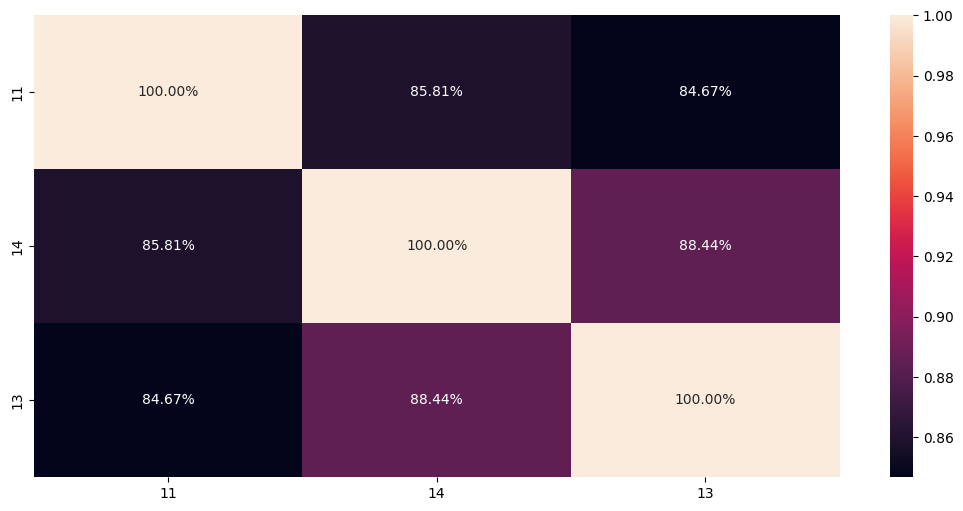

In [113]:
pred_concat_list=[]
for key, pred in predictions.items():
    pred_concat_list+=[pd.Series(pred, name=key)]
# checking how similiar their decision boundry
model_results = pd.concat(pred_concat_list,axis=1)
fig, ax = plt.subplots(figsize=(13,6) )
heatmap= sns.heatmap(model_results.corr(),annot=True,fmt=".2%")
plt.show()
plt.close()

In [114]:
print(roc_auc_score(test_label_computed, ensemble_pred))
print(f"Test stability score: {get_metric_calc_df(test_label_computed, ensemble_pred, 'train')}")

0.8110779452986365
Test stability score: 0.5534806746430252


#### Cleaning Memory

In [115]:
del test_computed, train_computed, valid_computed
del dtrain, dvalid, dtest 
collect()

140

#### Loading model and pipeline

### Predicting test set

In [116]:
# test_d0_1 = dd.read_parquet(data_dir+"test_d0_1_v5.parquet") 
_,_,test_d0_1 =sp.read_process_splits(ftype="test", verbose=False)
print(f"Test shape: {len(test_d0_1)}, {test_d0_1.shape[1]}, Memory Size: {round(test_d0_1.memory_usage().sum().compute() / 1024**2,2)}" )

test_deposit_1
test_debitcard_1
test_other_1
test_base
test_person_1
test_applprev_1
test_static_0
test_static_cb_0
test_tax_registry_b_1
test_tax_registry_a_1
test_credit_bureau_b_1
test_credit_bureau_a_1
select_numeric_features beginning shape of full df (10, 823)
shape of df before merge with numeric (10, 325)
shape of df after merge with numeric (10, 764)
select_numeric_features ended shape of full df (10, 764), # of numeric features 439, cat features 83, time_features: 242
Test shape: 10, 722, Memory Size: 0.03


In [117]:
#dtest_d0_1 = xgb.DMatrix(data=test_d0_1.compute())
test_d0_1 = test_d0_1.compute()

In [118]:
#prediction_test = xgb_tune_dart.predict(dtest_d0_1)
prediction_test, predictions_test_dict=aggragate_prediction(top_10_xgb_dart_model_dict,xtest=test_d0_1)

In [119]:
#y_pred = pd.Series(prediction_test, index=test_d0_1.index.compute())
y_pred = pd.Series(prediction_test, index=test_d0_1.index)
df_subm = pd.read_csv(os.path.join(G.data_dir, "sample_submission.csv"))
df_subm = df_subm.set_index("case_id")

In [120]:
df_subm["score"] = y_pred
df_subm.to_csv("submission.csv")
#df_subm